In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [17]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [19]:
tree_names_nohits = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [20]:
tree_names_hits = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [21]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names_nohits, channel_names)]

In [22]:
files[3].aliases = {
    'B_FD': "D_FD",
    'B_FD_TRUE': "D_FD_TRUE",
}

In [23]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [24]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [25]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [26]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2, true=True):
    feature = "q2_TRUE" if true else "q2"
    return join_and("%s > %g" % (feature, v1), "%s < %g" % (feature, v2))

In [27]:
def e_selectors(true=True):
    q_Kll_selector = q2_range(1.1, 6.0, true)
    q_Jpsi_e_selector = q2_range(6.0, 12.96, true)
    q_psi2S_e_selector = q2_range(9.82, 16.40, true)
    selectors = [
        q_Kll_selector,
        q_Jpsi_e_selector,
        q_psi2S_e_selector,
        "True",
    ]
    return selectors

#q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [28]:
selectors_true = e_selectors(True)
selectors_notrue = e_selectors(False)

In [29]:
selected_true = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_true)]
selected_notrue = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_notrue)]

In [30]:
splitted_true = [split(f, shuffle=True, test_size=0.2) for f in selected_true]
train_ds_true = [x[0] for x in splitted_true]
test_ds_true = [x[1] for x in splitted_true]

In [31]:
splitted_notrue = [split(f, shuffle=True, test_size=0.2) for f in selected_notrue]
train_ds_notrue = [x[0] for x in splitted_notrue]
test_ds_notrue = [x[1] for x in splitted_notrue]

In [32]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected_true:
    df.loc[f.name(), "Selected true"] = len(f)
for f in train_ds_true:
    df.loc[f.name(), "Train true"] = len(f)
for f in test_ds_true:
    df.loc[f.name(), "Test true"] = len(f)
for f in selected_notrue:
    df.loc[f.name(), "Selected notrue"] = len(f)
for f in train_ds_notrue:
    df.loc[f.name(), "Train notrue"] = len(f)
for f in test_ds_notrue:
    df.loc[f.name(), "Test notrue"] = len(f)
df["Selected/Total true"] = df["Selected true"] / df["Total"]
df["Selected/Total notrue"] = df["Selected notrue"] / df["Total"]
df

#Events             Total  Selected true  Train true  Test true  \
B⁺→K⁺ee          970116.0       247104.0    197683.0    49421.0   
B⁺→K⁺J/ψ(→ee)    960234.0       929755.0    743804.0   185951.0   
B⁺→K⁺ψ(2S)(→ee)  986271.0       939679.0    751743.0   187936.0   
D⁺→π⁺φ(→ee)      830027.0       830027.0    664021.0   166006.0   

#Events          Selected notrue  Train notrue  Test notrue  \
B⁺→K⁺ee                 296675.0      237340.0      59335.0   
B⁺→K⁺J/ψ(→ee)           845739.0      676591.0     169148.0   
B⁺→K⁺ψ(2S)(→ee)         768614.0      614891.0     153723.0   
D⁺→π⁺φ(→ee)             830027.0      664021.0     166006.0   

#Events          Selected/Total true  Selected/Total notrue  
B⁺→K⁺ee                     0.254716               0.305814  
B⁺→K⁺J/ψ(→ee)               0.968259               0.880763  
B⁺→K⁺ψ(2S)(→ee)             0.952759               0.779313  
D⁺→π⁺φ(→ee)                 1.000000               1.000000

### KS tests

In [33]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [34]:
perform_ks_test(train_ds_notrue, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [35]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [36]:
aliases = {
    "min_e_IP_TRUE": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT_TRUE": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP_TRUE": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
    "max_e_P_TRUE": "fmax(ep_P_TRUE,em_P_TRUE)",
    
    "min_e_IP": "fmin(ep_IP,em_IP)",
    "max_e_PT": "fmax(ep_PT,em_PT)",
    "max_e_P": "fmax(ep_P,em_P)",
}

In [37]:
def features_plots(ds):
    feature_plot("log(B_FD)", ds, aliases, 101)
    feature_plot("log(max_e_SIGMAIP_TRUE)", ds, aliases, 101)
    feature_plot("log(angle_ee)", ds, aliases, 101)
    feature_plot("log(min_e_IP)", ds, aliases, 101)
    feature_plot("log(max_e_PT)", ds, aliases, 101)
    feature_plot("log(max_e_P)", ds, aliases, 101)

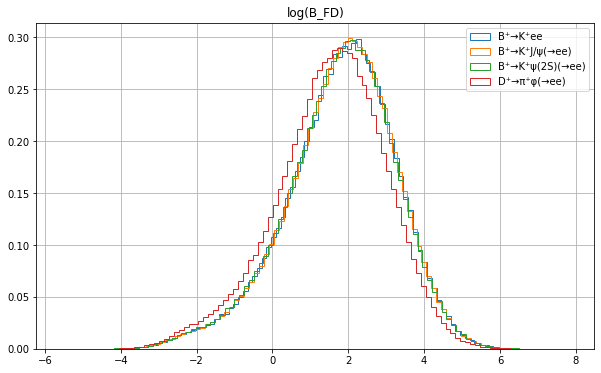

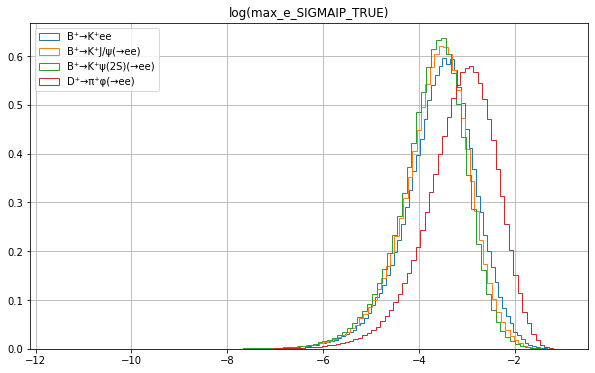

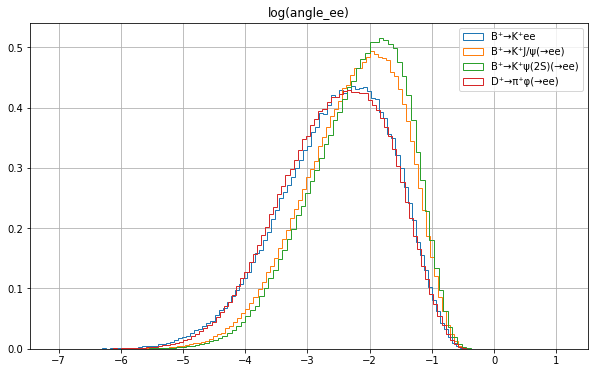

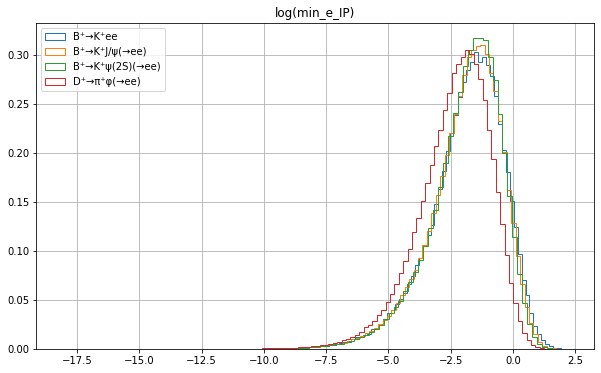

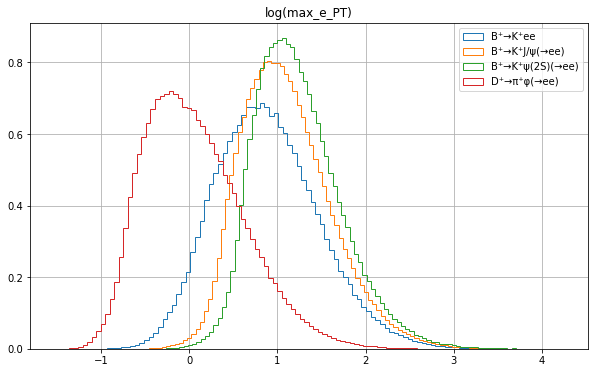

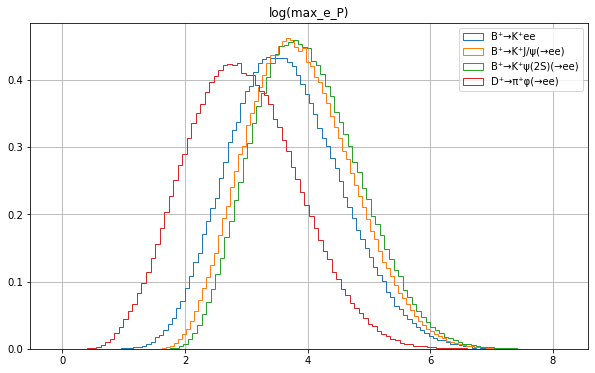

In [38]:
features_plots(train_ds_notrue)

### Preprocessing

In [39]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [40]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [41]:
feature_sets = [
    ("α,p", ["log(angle_ee)", "log(max_e_P)"]),
    ("2", ["log(angle_ee)", "log(max_e_PT)"]),
    ("3", ["log(B_FD)", "log(angle_ee)", "log(max_e_PT)"]),
    ("4", ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_PT)"]),
    ("5", ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_PT)", "log(max_e_SIGMAIP_TRUE)"]),
]
train_datasets = [
    ("₄", train_ds_notrue),
    ("₃", train_ds_notrue[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[α,p],
 DS₃[α,p],
 DS₄[2],
 DS₃[2],
 DS₄[3],
 DS₃[3],
 DS₄[4],
 DS₃[4],
 DS₄[5],
 DS₃[5]]

In [42]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [43]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [44]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [45]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [46]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [47]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [48]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [49]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.424495
INFO:root:Epoch 1, 1.382864
INFO:root:Epoch 2, 1.374328
INFO:root:Epoch 3, 1.359493
INFO:root:Epoch 4, 1.326073
INFO:root:Epoch 5, 1.252874
INFO:root:Epoch 6, 1.123349
INFO:root:Epoch 7, 0.975511
INFO:root:Epoch 8, 0.898071
INFO:root:Epoch 9, 0.880807
INFO:root:Epoch 10, 0.876955
INFO:root:Epoch 11, 0.873535
INFO:root:Epoch 12, 0.870241
INFO:root:Epoch 13, 0.867122
INFO:root:Epoch 14, 0.864179
INFO:root:Epoch 15, 0.861360
INFO:root:Epoch 16, 0.858522
INFO:root:Epoch 17, 0.855749
INFO:root:Epoch 18, 0.853041
INFO:root:Epoch 19, 0.850442
INFO:root:Epoch 20, 0.847976
INFO:root:Epoch 21, 0.845717
INFO:root:Epoch 22, 0.843621
INFO:root:Epoch 23, 0.841696
INFO:root:Epoch 24, 0.840021
INFO:root:Epoch 25, 0.838505
INFO:root:Epoch 26, 0.837173
INFO:root:Epoch 27, 0.835978
INFO:root:Epoch 28, 0.834933
INFO:root:Epoch 29, 0.834030
INFO:root:Epoch 30, 0.833094
INFO:root:Epoch 31, 0.832293
INFO:root:Epoch 32, 0.831563
INFO:root:Epoch 33, 0.830893
INFO:root:Epoch 34, 0.83

INFO:root:Epoch 35, 1.018786
INFO:root:Epoch 36, 1.018770
INFO:root:Epoch 37, 1.018759
INFO:root:Epoch 38, 1.018760
INFO:root:Epoch 39, 1.018766
INFO:root:Epoch 40, 1.018760
INFO:root:Epoch 41, 1.018744
INFO:root:Epoch 42, 1.018731
INFO:root:Epoch 43, 1.018731
INFO:root:Epoch 44, 1.018733
INFO:root:Epoch 45, 1.018727
INFO:root:Epoch 46, 1.018717
INFO:root:Epoch 47, 1.018709
INFO:root:Epoch 48, 1.018704
INFO:root:Epoch 49, 1.018700
INFO:root:Epoch 0, 1.098890
INFO:root:Epoch 1, 1.090719
INFO:root:Epoch 2, 1.082156
INFO:root:Epoch 3, 1.068671
INFO:root:Epoch 4, 1.049079
INFO:root:Epoch 5, 1.027746
INFO:root:Epoch 6, 1.013695
INFO:root:Epoch 7, 1.009819
INFO:root:Epoch 8, 1.008741
INFO:root:Epoch 9, 1.007735
INFO:root:Epoch 10, 1.006933
INFO:root:Epoch 11, 1.006253
INFO:root:Epoch 12, 1.005641
INFO:root:Epoch 13, 1.005120
INFO:root:Epoch 14, 1.004615
INFO:root:Epoch 15, 1.004199
INFO:root:Epoch 16, 1.003817
INFO:root:Epoch 17, 1.003442
INFO:root:Epoch 18, 1.003127
INFO:root:Epoch 19, 1.00

INFO:root:Epoch 20, 0.993112
INFO:root:Epoch 21, 0.993056
INFO:root:Epoch 22, 0.993060
INFO:root:Epoch 23, 0.993098
INFO:root:Epoch 24, 0.993105
INFO:root:Epoch 25, 0.993068
INFO:root:Epoch 26, 0.993033
INFO:root:Epoch 27, 0.993033
INFO:root:Epoch 28, 0.993053
INFO:root:Epoch 29, 0.993053
INFO:root:Epoch 30, 0.993030
INFO:root:Epoch 31, 0.993009
INFO:root:Epoch 32, 0.993009
INFO:root:Epoch 33, 0.993017
INFO:root:Epoch 34, 0.993013
INFO:root:Epoch 35, 0.992996
INFO:root:Epoch 36, 0.992985
INFO:root:Epoch 37, 0.992985
INFO:root:Epoch 38, 0.992986
INFO:root:Epoch 39, 0.992979
INFO:root:Epoch 40, 0.992967
INFO:root:Epoch 41, 0.992961
INFO:root:Epoch 42, 0.992960
INFO:root:Epoch 43, 0.992957
INFO:root:Epoch 44, 0.992949
INFO:root:Epoch 45, 0.992941
INFO:root:Epoch 46, 0.992937
INFO:root:Epoch 47, 0.992934
INFO:root:Epoch 48, 0.992928
INFO:root:Epoch 49, 0.992921
INFO:root:Epoch 0, 1.478710
INFO:root:Epoch 1, 1.390645
INFO:root:Epoch 2, 1.377912
INFO:root:Epoch 3, 1.363778
INFO:root:Epoch 4,

INFO:root:Epoch 5, 0.977586
INFO:root:Epoch 6, 0.976738
INFO:root:Epoch 7, 0.976497
INFO:root:Epoch 8, 0.976917
INFO:root:Epoch 9, 0.977250
INFO:root:Epoch 10, 0.977065
INFO:root:Epoch 11, 0.976643
INFO:root:Epoch 12, 0.976431
INFO:root:Epoch 13, 0.976561
INFO:root:Epoch 14, 0.976786
INFO:root:Epoch 15, 0.976821
INFO:root:Epoch 16, 0.976639
INFO:root:Epoch 17, 0.976431
INFO:root:Epoch 18, 0.976383
INFO:root:Epoch 19, 0.976490
INFO:root:Epoch 20, 0.976587
INFO:root:Epoch 21, 0.976551
INFO:root:Epoch 22, 0.976420
INFO:root:Epoch 23, 0.976326
INFO:root:Epoch 24, 0.976339
INFO:root:Epoch 25, 0.976406
INFO:root:Epoch 26, 0.976427
INFO:root:Epoch 27, 0.976369
INFO:root:Epoch 28, 0.976289
INFO:root:Epoch 29, 0.976258
INFO:root:Epoch 30, 0.976284
INFO:root:Epoch 31, 0.976311
INFO:root:Epoch 32, 0.976290
INFO:root:Epoch 33, 0.976236
INFO:root:Epoch 34, 0.976198
INFO:root:Epoch 35, 0.976200
INFO:root:Epoch 36, 0.976215
INFO:root:Epoch 37, 0.976207
INFO:root:Epoch 38, 0.976172
INFO:root:Epoch 39,

CPU times: user 4min 50s, sys: 17.2 s, total: 5min 7s
Wall time: 5min 5s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [50]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [51]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [52]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [53]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [54]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

### Weighting function

In [55]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [56]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [57]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [58]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [59]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [60]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [61]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [62]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [63]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [64]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000076 W+c=[ 5.1277 -5.1794  2.4807 -1.4059] det=0.000040 L=0.312337
Epoch 1 loss=-4.000076 W+c=[ 5.1188 -5.1582  2.4543 -1.41  ] det=0.000040 L=0.313064
Epoch 2 loss=-4.000077 W+c=[ 5.1102 -5.1373  2.4285 -1.414 ] det=0.000041 L=0.313795
Epoch 3 loss=-4.000078 W+c=[ 5.1017 -5.1166  2.4031 -1.4181] det=0.000041 L=0.314530
Epoch 4 loss=-4.000076 W+c=[ 5.0934 -5.0961  2.3781 -1.422 ] det=0.000042 L=0.315269
Epoch 5 loss=-4.000077 W+c=[ 5.0853 -5.0759  2.3536 -1.4259] det=0.000042 L=0.316012
Epoch 6 loss=-4.000078 W+c=[ 5.0773 -5.0558  2.3295 -1.4298] det=0.000042 L=0.316759
Epoch 7 loss=-4.000077 W+c=[ 5.0695 -5.036   2.3058 -1.4336] det=0.000043 L=0.317509
Epoch 8 loss=-4.000077 W+c=[ 5.0619 -5.0163  2.2825 -1.4374] det=0.000043 L=0.318264
Epoch 9 loss=-4.000078 W+c=[ 5.0544 -4.9969  2.2596 -1.4411] det=0.000044 L=0.319021
Epoch 10 loss=-4.000077 W+c=[ 5.047  -4.9776  2.2371 -1.4447] det=0.000044 L=0.319783
Epoch 11 loss=-4.000077 W+c=[ 5.0398 -4.9586  2.215  -1.4483] de

Epoch 96 loss=-4.000080 W+c=[ 4.7279 -3.7953  1.1532 -1.6142] det=0.000085 L=0.394638
Epoch 97 loss=-4.000079 W+c=[ 4.726  -3.7852  1.1463 -1.6151] det=0.000086 L=0.395584
Epoch 98 loss=-4.000079 W+c=[ 4.7242 -3.7751  1.1395 -1.6159] det=0.000086 L=0.396529
Epoch 99 loss=-4.000078 W+c=[ 4.7225 -3.7651  1.1328 -1.6167] det=0.000087 L=0.397475
Epoch 100 loss=-4.000079 W+c=[ 4.7207 -3.7551  1.1262 -1.6175] det=0.000087 L=0.398421
Epoch 101 loss=-4.000079 W+c=[ 4.719  -3.7452  1.1196 -1.6183] det=0.000088 L=0.399367
Epoch 102 loss=-4.000081 W+c=[ 4.7172 -3.7353  1.1131 -1.6191] det=0.000088 L=0.400313
Epoch 103 loss=-4.000079 W+c=[ 4.7155 -3.7255  1.1067 -1.6199] det=0.000089 L=0.401259
Epoch 104 loss=-4.000079 W+c=[ 4.7138 -3.7157  1.1004 -1.6206] det=0.000089 L=0.402205
Epoch 105 loss=-4.000078 W+c=[ 4.7121 -3.706   1.0941 -1.6214] det=0.000089 L=0.403151
Epoch 106 loss=-4.000080 W+c=[ 4.7105 -3.6963  1.0878 -1.6221] det=0.000090 L=0.404097
Epoch 107 loss=-4.000079 W+c=[ 4.7088 -3.6867  

Epoch 191 loss=-4.000080 W+c=[ 4.602  -3.0252  0.7285 -1.6555] det=0.000131 L=0.489531
Epoch 192 loss=-4.000079 W+c=[ 4.6009 -3.0187  0.7256 -1.6557] det=0.000132 L=0.490687
Epoch 193 loss=-4.000080 W+c=[ 4.5998 -3.0123  0.7228 -1.6558] det=0.000132 L=0.491842
Epoch 194 loss=-4.000079 W+c=[ 4.5988 -3.0059  0.72   -1.656 ] det=0.000132 L=0.492996
Epoch 195 loss=-4.000080 W+c=[ 4.5977 -2.9995  0.7172 -1.6562] det=0.000133 L=0.494150
Epoch 196 loss=-4.000080 W+c=[ 4.5966 -2.9931  0.7145 -1.6564] det=0.000133 L=0.495304
Epoch 197 loss=-4.000081 W+c=[ 4.5956 -2.9868  0.7117 -1.6566] det=0.000134 L=0.496458
Epoch 198 loss=-4.000080 W+c=[ 4.5945 -2.9805  0.709  -1.6567] det=0.000134 L=0.497611
Epoch 199 loss=-4.000080 W+c=[ 4.5934 -2.9742  0.7063 -1.6569] det=0.000135 L=0.498763
W= [[0.3888 0.139  0.0743 0.2683]
 [0.2121 0.3303 0.2689 0.0287]
 [0.2139 0.5175 0.6546 0.0077]
 [0.1851 0.0132 0.0022 0.6954]]
W+= [[ 4.5924 -2.9679  0.7036 -1.6571]
 [-4.5959 11.4896 -4.2021  1.346 ]
 [ 2.1457 -8.11

Epoch 82 loss=-12.748680 W+c=[ 9.0244 -0.5276  0.3841 -1.0114] det=0.000091 L=3.128456
Epoch 83 loss=-12.743484 W+c=[ 9.0203 -0.5247  0.3825 -1.0095] det=0.000092 L=3.139657
Epoch 84 loss=-12.738461 W+c=[ 9.016  -0.5218  0.3809 -1.0075] det=0.000092 L=3.150775
Epoch 85 loss=-12.733616 W+c=[ 9.0116 -0.5191  0.3794 -1.0056] det=0.000092 L=3.161812
Epoch 86 loss=-12.728936 W+c=[ 9.0072 -0.5163  0.3778 -1.0036] det=0.000093 L=3.172768
Epoch 87 loss=-12.724412 W+c=[ 9.0026 -0.5136  0.3762 -1.0017] det=0.000093 L=3.183647
Epoch 88 loss=-12.720042 W+c=[ 8.9979 -0.511   0.3747 -0.9999] det=0.000094 L=3.194448
Epoch 89 loss=-12.715799 W+c=[ 8.9932 -0.5083  0.3732 -0.998 ] det=0.000094 L=3.205175
Epoch 90 loss=-12.711705 W+c=[ 8.9884 -0.5058  0.3716 -0.9961] det=0.000095 L=3.215826
Epoch 91 loss=-12.707725 W+c=[ 8.9835 -0.5032  0.3701 -0.9943] det=0.000095 L=3.226406
Epoch 92 loss=-12.703859 W+c=[ 8.9786 -0.5007  0.3686 -0.9925] det=0.000095 L=3.236913
Epoch 93 loss=-12.700115 W+c=[ 8.9736 -0.49

Epoch 176 loss=-12.523999 W+c=[ 8.5626 -0.3688  0.2649 -0.8832] det=0.000136 L=3.982365
Epoch 177 loss=-12.522337 W+c=[ 8.5584 -0.3678  0.2639 -0.8823] det=0.000136 L=3.990016
Epoch 178 loss=-12.520685 W+c=[ 8.5543 -0.3668  0.263  -0.8813] det=0.000137 L=3.997637
Epoch 179 loss=-12.519041 W+c=[ 8.5502 -0.3657  0.262  -0.8804] det=0.000137 L=4.005229
Epoch 180 loss=-12.517394 W+c=[ 8.5461 -0.3648  0.2611 -0.8795] det=0.000138 L=4.012795
Epoch 181 loss=-12.515749 W+c=[ 8.542  -0.3638  0.2601 -0.8786] det=0.000138 L=4.020336
Epoch 182 loss=-12.514107 W+c=[ 8.5379 -0.3628  0.2592 -0.8777] det=0.000139 L=4.027845
Epoch 183 loss=-12.512477 W+c=[ 8.5338 -0.3618  0.2582 -0.8768] det=0.000139 L=4.035327
Epoch 184 loss=-12.510839 W+c=[ 8.5298 -0.3608  0.2573 -0.8759] det=0.000140 L=4.042784
Epoch 185 loss=-12.509203 W+c=[ 8.5258 -0.3599  0.2564 -0.875 ] det=0.000140 L=4.050214
Epoch 186 loss=-12.507576 W+c=[ 8.5218 -0.3589  0.2555 -0.8741] det=0.000141 L=4.057617
Epoch 187 loss=-12.505945 W+c=[ 

Epoch 270 loss=-12.378397 W+c=[ 8.2459 -0.2986  0.1946 -0.8153] det=0.000180 L=4.616289
Epoch 271 loss=-12.376959 W+c=[ 8.2433 -0.298   0.1941 -0.8148] det=0.000180 L=4.622374
Epoch 272 loss=-12.375520 W+c=[ 8.2406 -0.2975  0.1935 -0.8142] det=0.000181 L=4.628438
Epoch 273 loss=-12.374076 W+c=[ 8.2379 -0.2969  0.1929 -0.8137] det=0.000181 L=4.634482
Epoch 274 loss=-12.372638 W+c=[ 8.2352 -0.2964  0.1924 -0.8131] det=0.000182 L=4.640514
Epoch 275 loss=-12.371200 W+c=[ 8.2326 -0.2959  0.1918 -0.8126] det=0.000182 L=4.646526
Epoch 276 loss=-12.369770 W+c=[ 8.2299 -0.2953  0.1913 -0.812 ] det=0.000182 L=4.652517
Epoch 277 loss=-12.368337 W+c=[ 8.2273 -0.2948  0.1907 -0.8115] det=0.000183 L=4.658494
Epoch 278 loss=-12.366915 W+c=[ 8.2247 -0.2943  0.1902 -0.811 ] det=0.000183 L=4.664451
Epoch 279 loss=-12.365489 W+c=[ 8.2221 -0.2937  0.1897 -0.8104] det=0.000184 L=4.670389
Epoch 280 loss=-12.364065 W+c=[ 8.2195 -0.2932  0.1891 -0.8099] det=0.000184 L=4.676310
Epoch 281 loss=-12.362651 W+c=[ 

Epoch 364 loss=-12.253095 W+c=[ 8.0343 -0.2578  0.1529 -0.7722] det=0.000218 L=5.111753
Epoch 365 loss=-12.251880 W+c=[ 8.0324 -0.2574  0.1525 -0.7718] det=0.000218 L=5.116219
Epoch 366 loss=-12.250665 W+c=[ 8.0305 -0.2571  0.1522 -0.7715] det=0.000218 L=5.120822
Epoch 367 loss=-12.249444 W+c=[ 8.0287 -0.2568  0.1518 -0.7711] det=0.000219 L=5.126169
Epoch 368 loss=-12.248235 W+c=[ 8.0268 -0.2564  0.1515 -0.7707] det=0.000219 L=5.131503
Epoch 369 loss=-12.247029 W+c=[ 8.025  -0.2561  0.1512 -0.7703] det=0.000220 L=5.136827
Epoch 370 loss=-12.245817 W+c=[ 8.0231 -0.2557  0.1508 -0.77  ] det=0.000220 L=5.142132
Epoch 371 loss=-12.244613 W+c=[ 8.0213 -0.2554  0.1505 -0.7696] det=0.000220 L=5.147427
Epoch 372 loss=-12.243412 W+c=[ 8.0195 -0.2551  0.1501 -0.7692] det=0.000221 L=5.152709
Epoch 373 loss=-12.242211 W+c=[ 8.0176 -0.2547  0.1498 -0.7689] det=0.000221 L=5.157975
Epoch 374 loss=-12.241013 W+c=[ 8.0158 -0.2544  0.1495 -0.7685] det=0.000221 L=5.163229
Epoch 375 loss=-12.239818 W+c=[ 

Epoch 458 loss=-12.148438 W+c=[ 7.8828 -0.2308  0.1263 -0.7419] det=0.000250 L=5.558252
Epoch 459 loss=-12.147419 W+c=[ 7.8815 -0.2306  0.1261 -0.7416] det=0.000250 L=5.562404
Epoch 460 loss=-12.146410 W+c=[ 7.8801 -0.2304  0.1259 -0.7413] det=0.000250 L=5.566545
Epoch 461 loss=-12.145409 W+c=[ 7.8787 -0.2301  0.1257 -0.741 ] det=0.000250 L=5.570674
Epoch 462 loss=-12.144399 W+c=[ 7.8773 -0.2299  0.1254 -0.7408] det=0.000251 L=5.574789
Epoch 463 loss=-12.143398 W+c=[ 7.876  -0.2297  0.1252 -0.7405] det=0.000251 L=5.578890
Epoch 464 loss=-12.142401 W+c=[ 7.8746 -0.2294  0.125  -0.7402] det=0.000251 L=5.582984
Epoch 465 loss=-12.141395 W+c=[ 7.8732 -0.2292  0.1248 -0.74  ] det=0.000252 L=5.587060
Epoch 466 loss=-12.140396 W+c=[ 7.8719 -0.229   0.1245 -0.7397] det=0.000252 L=5.591127
Epoch 467 loss=-12.139400 W+c=[ 7.8705 -0.2287  0.1243 -0.7394] det=0.000252 L=5.595182
Epoch 468 loss=-12.138410 W+c=[ 7.8692 -0.2285  0.1241 -0.7391] det=0.000253 L=5.599217
Epoch 469 loss=-12.137425 W+c=[ 

Epoch 54 loss=-3.000084 W+c=[ 2.1954 -2.2541  1.1047] det=0.000512 L=0.353823
Epoch 55 loss=-3.000083 W+c=[ 2.1956 -2.2511  1.1023] det=0.000513 L=0.354291
Epoch 56 loss=-3.000084 W+c=[ 2.1958 -2.248   1.0999] det=0.000515 L=0.354760
Epoch 57 loss=-3.000085 W+c=[ 2.196  -2.245   1.0975] det=0.000516 L=0.355228
Epoch 58 loss=-3.000084 W+c=[ 2.1962 -2.242   1.0952] det=0.000517 L=0.355696
Epoch 59 loss=-3.000083 W+c=[ 2.1964 -2.239   1.0928] det=0.000518 L=0.356164
Epoch 60 loss=-3.000084 W+c=[ 2.1966 -2.236   1.0905] det=0.000519 L=0.356631
Epoch 61 loss=-3.000084 W+c=[ 2.1968 -2.233   1.0881] det=0.000521 L=0.357099
Epoch 62 loss=-3.000084 W+c=[ 2.1971 -2.23    1.0858] det=0.000522 L=0.357566
Epoch 63 loss=-3.000085 W+c=[ 2.1973 -2.227   1.0834] det=0.000523 L=0.358034
Epoch 64 loss=-3.000085 W+c=[ 2.1975 -2.224   1.0811] det=0.000524 L=0.358501
Epoch 65 loss=-3.000086 W+c=[ 2.1977 -2.221   1.0788] det=0.000526 L=0.358968
Epoch 66 loss=-3.000085 W+c=[ 2.1979 -2.218   1.0765] det=0.0005

Epoch 159 loss=-3.000082 W+c=[ 2.2173 -1.9641  0.8838] det=0.000651 L=0.405086
Epoch 160 loss=-3.000081 W+c=[ 2.2175 -1.9616  0.8819] det=0.000653 L=0.405661
Epoch 161 loss=-3.000083 W+c=[ 2.2177 -1.9591  0.8801] det=0.000654 L=0.406236
Epoch 162 loss=-3.000082 W+c=[ 2.218  -1.9566  0.8782] det=0.000656 L=0.406811
Epoch 163 loss=-3.000083 W+c=[ 2.2182 -1.9541  0.8764] det=0.000657 L=0.407386
Epoch 164 loss=-3.000082 W+c=[ 2.2184 -1.9516  0.8746] det=0.000659 L=0.407961
Epoch 165 loss=-3.000082 W+c=[ 2.2186 -1.9491  0.8728] det=0.000660 L=0.408536
Epoch 166 loss=-3.000081 W+c=[ 2.2188 -1.9467  0.8709] det=0.000661 L=0.409110
Epoch 167 loss=-3.000082 W+c=[ 2.219  -1.9442  0.8691] det=0.000663 L=0.409684
Epoch 168 loss=-3.000082 W+c=[ 2.2192 -1.9417  0.8673] det=0.000664 L=0.410259
Epoch 169 loss=-3.000083 W+c=[ 2.2194 -1.9393  0.8655] det=0.000666 L=0.410833
Epoch 170 loss=-3.000082 W+c=[ 2.2196 -1.9368  0.8637] det=0.000667 L=0.411407
Epoch 171 loss=-3.000082 W+c=[ 2.2198 -1.9344  0.861

Epoch 61 loss=-7.556145 W+c=[ 3.4529 -0.2068  0.0845] det=0.000696 L=3.420845
Epoch 62 loss=-7.510463 W+c=[ 3.4603 -0.2037  0.0835] det=0.000694 L=3.477514
Epoch 63 loss=-7.466253 W+c=[ 3.4674 -0.2007  0.0826] det=0.000692 L=3.533863
Epoch 64 loss=-7.423438 W+c=[ 3.4743 -0.1978  0.0817] det=0.000690 L=3.589921
Epoch 65 loss=-7.381963 W+c=[ 3.4809 -0.195   0.0808] det=0.000687 L=3.645725
Epoch 66 loss=-7.341780 W+c=[ 3.4873 -0.1923  0.08  ] det=0.000685 L=3.701297
Epoch 67 loss=-7.302810 W+c=[ 3.4935 -0.1896  0.0792] det=0.000684 L=3.756665
Epoch 68 loss=-7.265032 W+c=[ 3.4995 -0.187   0.0784] det=0.000682 L=3.811849
Epoch 69 loss=-7.228376 W+c=[ 3.5052 -0.1845  0.0776] det=0.000680 L=3.866886
Epoch 70 loss=-7.192808 W+c=[ 3.5107 -0.182   0.0769] det=0.000678 L=3.921798
Epoch 71 loss=-7.158272 W+c=[ 3.5161 -0.1797  0.0762] det=0.000677 L=3.979787
Epoch 72 loss=-7.124735 W+c=[ 3.5212 -0.1773  0.0755] det=0.000675 L=4.040689
Epoch 73 loss=-7.092150 W+c=[ 3.5262 -0.1751  0.0748] det=0.0006

Epoch 166 loss=-5.840158 W+c=[ 3.5834 -0.0838  0.0486] det=0.000728 L=5.550676
Epoch 167 loss=-5.834628 W+c=[ 3.5823 -0.0834  0.0485] det=0.000730 L=5.554565
Epoch 168 loss=-5.829173 W+c=[ 3.5811 -0.0829  0.0483] det=0.000731 L=5.558392
Epoch 169 loss=-5.823773 W+c=[ 3.58   -0.0825  0.0482] det=0.000733 L=5.562151
Epoch 170 loss=-5.818444 W+c=[ 3.5789 -0.0821  0.048 ] det=0.000735 L=5.565846
Epoch 171 loss=-5.813178 W+c=[ 3.5777 -0.0817  0.0479] det=0.000737 L=5.569470
Epoch 172 loss=-5.807977 W+c=[ 3.5765 -0.0813  0.0477] det=0.000738 L=5.573027
Epoch 173 loss=-5.802837 W+c=[ 3.5754 -0.0809  0.0476] det=0.000740 L=5.576514
Epoch 174 loss=-5.797757 W+c=[ 3.5742 -0.0805  0.0475] det=0.000742 L=5.580288
Epoch 175 loss=-5.792728 W+c=[ 3.573  -0.0801  0.0473] det=0.000744 L=5.584110
Epoch 176 loss=-5.787763 W+c=[ 3.5718 -0.0797  0.0472] det=0.000746 L=5.587866
Epoch 177 loss=-5.782857 W+c=[ 3.5706 -0.0794  0.047 ] det=0.000747 L=5.591557
Epoch 178 loss=-5.778001 W+c=[ 3.5694 -0.079   0.046

Epoch 270 loss=-5.479421 W+c=[ 3.459  -0.0563  0.0361] det=0.000957 L=6.029292
Epoch 271 loss=-5.477172 W+c=[ 3.4579 -0.0561  0.036 ] det=0.000959 L=6.033761
Epoch 272 loss=-5.474946 W+c=[ 3.4568 -0.056   0.0359] det=0.000962 L=6.038167
Epoch 273 loss=-5.472730 W+c=[ 3.4558 -0.0558  0.0358] det=0.000964 L=6.042515
Epoch 274 loss=-5.470534 W+c=[ 3.4547 -0.0557  0.0357] det=0.000967 L=6.046800
Epoch 275 loss=-5.468344 W+c=[ 3.4536 -0.0555  0.0356] det=0.000969 L=6.051023
Epoch 276 loss=-5.466171 W+c=[ 3.4526 -0.0553  0.0355] det=0.000972 L=6.055188
Epoch 277 loss=-5.464011 W+c=[ 3.4515 -0.0552  0.0354] det=0.000975 L=6.059290
Epoch 278 loss=-5.461861 W+c=[ 3.4504 -0.055   0.0353] det=0.000977 L=6.063334
Epoch 279 loss=-5.459729 W+c=[ 3.4494 -0.0549  0.0352] det=0.000980 L=6.067316
Epoch 280 loss=-5.457600 W+c=[ 3.4483 -0.0547  0.0351] det=0.000983 L=6.071238
Epoch 281 loss=-5.455494 W+c=[ 3.4473 -0.0546  0.035 ] det=0.000985 L=6.075101
Epoch 282 loss=-5.453393 W+c=[ 3.4463 -0.0544  0.034

Epoch 374 loss=-5.298933 W+c=[ 3.3643 -0.0438  0.027 ] det=0.001247 L=6.408307
Epoch 375 loss=-5.297571 W+c=[ 3.3635 -0.0437  0.027 ] det=0.001250 L=6.411636
Epoch 376 loss=-5.296210 W+c=[ 3.3628 -0.0437  0.0269] det=0.001253 L=6.414928
Epoch 377 loss=-5.294860 W+c=[ 3.362  -0.0436  0.0268] det=0.001256 L=6.418181
Epoch 378 loss=-5.293513 W+c=[ 3.3613 -0.0435  0.0268] det=0.001259 L=6.421395
Epoch 379 loss=-5.292170 W+c=[ 3.3605 -0.0434  0.0267] det=0.001262 L=6.424570
Epoch 380 loss=-5.290842 W+c=[ 3.3598 -0.0433  0.0266] det=0.001265 L=6.427705
Epoch 381 loss=-5.289501 W+c=[ 3.359  -0.0432  0.0265] det=0.001268 L=6.430804
Epoch 382 loss=-5.288178 W+c=[ 3.3583 -0.0431  0.0265] det=0.001271 L=6.433864
Epoch 383 loss=-5.286857 W+c=[ 3.3576 -0.0431  0.0264] det=0.001274 L=6.436886
Epoch 384 loss=-5.285548 W+c=[ 3.3568 -0.043   0.0263] det=0.001277 L=6.439871
Epoch 385 loss=-5.284227 W+c=[ 3.3561 -0.0429  0.0263] det=0.001280 L=6.442818
Epoch 386 loss=-5.282920 W+c=[ 3.3554 -0.0428  0.026

Epoch 478 loss=-5.179784 W+c=[ 3.2971 -0.0366  0.0206] det=0.001559 L=6.774354
Epoch 479 loss=-5.178818 W+c=[ 3.2965 -0.0365  0.0206] det=0.001562 L=6.776820
Epoch 480 loss=-5.177846 W+c=[ 3.296  -0.0365  0.0205] det=0.001565 L=6.779257
Epoch 481 loss=-5.176896 W+c=[ 3.2954 -0.0364  0.0205] det=0.001568 L=6.781667
Epoch 482 loss=-5.175941 W+c=[ 3.2949 -0.0364  0.0204] det=0.001571 L=6.784047
Epoch 483 loss=-5.174974 W+c=[ 3.2943 -0.0363  0.0203] det=0.001574 L=6.786400
Epoch 484 loss=-5.174033 W+c=[ 3.2938 -0.0362  0.0203] det=0.001577 L=6.788721
Epoch 485 loss=-5.173084 W+c=[ 3.2933 -0.0362  0.0202] det=0.001580 L=6.791018
Epoch 486 loss=-5.172129 W+c=[ 3.2927 -0.0361  0.0202] det=0.001583 L=6.793284
Epoch 487 loss=-5.171193 W+c=[ 3.2922 -0.0361  0.0201] det=0.001586 L=6.795524
Epoch 488 loss=-5.170248 W+c=[ 3.2916 -0.036   0.0201] det=0.001589 L=6.797735
Epoch 489 loss=-5.169316 W+c=[ 3.2911 -0.036   0.0201] det=0.001592 L=6.799917
Epoch 490 loss=-5.168372 W+c=[ 3.2906 -0.0359  0.02 

Epoch 70 loss=-4.000008 W+c=[ 30.1591 -43.071   23.9276  -5.4033] det=0.000000 L=0.077297
Epoch 71 loss=-4.000007 W+c=[ 30.1284 -42.9122  23.835   -5.4069] det=0.000000 L=0.077308
Epoch 72 loss=-4.000010 W+c=[ 30.0979 -42.7551  23.7433  -5.4105] det=0.000000 L=0.077318
Epoch 73 loss=-4.000010 W+c=[ 30.0677 -42.5996  23.6524  -5.4141] det=0.000000 L=0.077328
Epoch 74 loss=-4.000012 W+c=[ 30.0376 -42.4455  23.5621  -5.4177] det=0.000000 L=0.077339
Epoch 75 loss=-4.000007 W+c=[ 30.0077 -42.2929  23.4724  -5.4213] det=0.000000 L=0.077350
Epoch 76 loss=-4.000006 W+c=[ 29.978  -42.142   23.3836  -5.425 ] det=0.000000 L=0.077361
Epoch 77 loss=-4.000008 W+c=[ 29.9486 -41.9925  23.2955  -5.4286] det=0.000000 L=0.077372
Epoch 78 loss=-4.000008 W+c=[ 29.9193 -41.8443  23.208   -5.4323] det=0.000000 L=0.077382
Epoch 79 loss=-4.000007 W+c=[ 29.8901 -41.6975  23.1212  -5.436 ] det=0.000000 L=0.077393
Epoch 80 loss=-4.000009 W+c=[ 29.8612 -41.5523  23.0351  -5.4397] det=0.000000 L=0.077403
Epoch 81 l

Epoch 161 loss=-4.000013 W+c=[ 27.9569 -33.132   17.7485  -5.749 ] det=0.000000 L=0.078132
Epoch 162 loss=-4.000018 W+c=[ 27.9374 -33.0578  17.6991  -5.7527] det=0.000000 L=0.078140
Epoch 163 loss=-4.000018 W+c=[ 27.9178 -32.9837  17.6497  -5.7564] det=0.000000 L=0.078149
Epoch 164 loss=-4.000008 W+c=[ 27.898  -32.9099  17.6005  -5.7601] det=0.000000 L=0.078158
Epoch 165 loss=-4.000013 W+c=[ 27.8787 -32.8371  17.5519  -5.7638] det=0.000000 L=0.078166
Epoch 166 loss=-4.000013 W+c=[ 27.8592 -32.7645  17.5034  -5.7674] det=0.000000 L=0.078174
Epoch 167 loss=-4.000012 W+c=[ 27.8398 -32.6923  17.4551  -5.7711] det=0.000000 L=0.078183
Epoch 168 loss=-4.000009 W+c=[ 27.8205 -32.6208  17.4072  -5.7747] det=0.000000 L=0.078191
Epoch 169 loss=-4.000013 W+c=[ 27.8013 -32.5498  17.3596  -5.7784] det=0.000000 L=0.078199
Epoch 170 loss=-4.000011 W+c=[ 27.7821 -32.4791  17.3122  -5.782 ] det=0.000000 L=0.078207
Epoch 171 loss=-4.000015 W+c=[ 27.763  -32.4091  17.2651  -5.7857] det=0.000000 L=0.078216

Epoch 48 loss=-8.048052 W+c=[ 33.1223 -15.1391  14.719   -4.9451] det=0.000000 L=0.136573
Epoch 49 loss=-8.035931 W+c=[ 33.2302 -15.037   14.7012  -4.9316] det=0.000000 L=0.136970
Epoch 50 loss=-8.024047 W+c=[ 33.3366 -14.9377  14.6831  -4.9183] det=0.000000 L=0.137312
Epoch 51 loss=-8.012392 W+c=[ 33.4416 -14.8412  14.6646  -4.905 ] det=0.000000 L=0.137601
Epoch 52 loss=-8.000976 W+c=[ 33.5453 -14.7474  14.6458  -4.892 ] det=0.000000 L=0.137841
Epoch 53 loss=-7.989768 W+c=[ 33.6474 -14.656   14.6265  -4.879 ] det=0.000000 L=0.138033
Epoch 54 loss=-7.978795 W+c=[ 33.7481 -14.567   14.6068  -4.8662] det=0.000000 L=0.138182
Epoch 55 loss=-7.968028 W+c=[ 33.8473 -14.4804  14.5867  -4.8535] det=0.000000 L=0.138289
Epoch 56 loss=-7.957492 W+c=[ 33.9453 -14.396   14.5662  -4.841 ] det=0.000000 L=0.138358
Epoch 57 loss=-7.947146 W+c=[ 34.0417 -14.3137  14.5453  -4.8285] det=0.000000 L=0.138389
Epoch 58 loss=-7.937025 W+c=[ 34.1367 -14.2334  14.524   -4.8162] det=0.000000 L=0.138387
Epoch 59 l

Epoch 139 loss=-7.554599 W+c=[ 38.2221 -10.8966  12.1289  -4.1077] det=0.000000 L=0.132479
Epoch 140 loss=-7.553078 W+c=[ 38.2412 -10.8734  12.0971  -4.1013] det=0.000000 L=0.132559
Epoch 141 loss=-7.551611 W+c=[ 38.2599 -10.8504  12.0654  -4.0949] det=0.000000 L=0.132637
Epoch 142 loss=-7.550190 W+c=[ 38.2782 -10.8276  12.0338  -4.0886] det=0.000000 L=0.132714
Epoch 143 loss=-7.548803 W+c=[ 38.296  -10.805   12.0023  -4.0824] det=0.000000 L=0.132789
Epoch 144 loss=-7.547467 W+c=[ 38.3133 -10.7826  11.9707  -4.0761] det=0.000000 L=0.132863
Epoch 145 loss=-7.546158 W+c=[ 38.3301 -10.7603  11.9393  -4.0699] det=0.000000 L=0.132935
Epoch 146 loss=-7.544896 W+c=[ 38.3465 -10.7382  11.9079  -4.0638] det=0.000000 L=0.133007
Epoch 147 loss=-7.543680 W+c=[ 38.3626 -10.7164  11.8766  -4.0576] det=0.000000 L=0.133077
Epoch 148 loss=-7.542484 W+c=[ 38.3781 -10.6947  11.8452  -4.0515] det=0.000000 L=0.133145
Epoch 149 loss=-7.541340 W+c=[ 38.3931 -10.6731  11.814   -4.0455] det=0.000000 L=0.133213

Epoch 232 loss=-7.525343 W+c=[38.6967 -9.2743  9.5173 -3.6215] det=0.000000 L=0.137799
Epoch 233 loss=-7.525696 W+c=[38.6935 -9.2606  9.4935 -3.617 ] det=0.000000 L=0.137847
Epoch 234 loss=-7.526060 W+c=[38.6902 -9.2469  9.4698 -3.6125] det=0.000000 L=0.137894
Epoch 235 loss=-7.526417 W+c=[38.6869 -9.2332  9.4461 -3.6081] det=0.000000 L=0.137941
Epoch 236 loss=-7.526781 W+c=[38.6834 -9.2196  9.4225 -3.6037] det=0.000000 L=0.137987
Epoch 237 loss=-7.527160 W+c=[38.6798 -9.206   9.3991 -3.5992] det=0.000000 L=0.138033
Epoch 238 loss=-7.527544 W+c=[38.6763 -9.1925  9.3757 -3.5948] det=0.000000 L=0.138078
Epoch 239 loss=-7.527930 W+c=[38.6726 -9.1791  9.3524 -3.5904] det=0.000000 L=0.138122
Epoch 240 loss=-7.528313 W+c=[38.6688 -9.1657  9.3292 -3.586 ] det=0.000000 L=0.138167
Epoch 241 loss=-7.528711 W+c=[38.665  -9.1523  9.3061 -3.5817] det=0.000000 L=0.138210
Epoch 242 loss=-7.529113 W+c=[38.6611 -9.139   9.283  -3.5773] det=0.000000 L=0.138253
Epoch 243 loss=-7.529521 W+c=[38.6571 -9.12

Epoch 327 loss=-7.570864 W+c=[38.1964 -8.1415  7.606  -3.2297] det=0.000000 L=0.143617
Epoch 328 loss=-7.571356 W+c=[38.1905 -8.1311  7.5892 -3.2258] det=0.000000 L=0.143682
Epoch 329 loss=-7.571846 W+c=[38.1845 -8.1206  7.5723 -3.2219] det=0.000000 L=0.143747
Epoch 330 loss=-7.572337 W+c=[38.1786 -8.1103  7.5556 -3.2181] det=0.000000 L=0.143811
Epoch 331 loss=-7.572825 W+c=[38.1725 -8.0999  7.5389 -3.2142] det=0.000000 L=0.143874
Epoch 332 loss=-7.573314 W+c=[38.1666 -8.0896  7.5223 -3.2103] det=0.000000 L=0.143937
Epoch 333 loss=-7.573806 W+c=[38.1607 -8.0792  7.5057 -3.2065] det=0.000000 L=0.143999
Epoch 334 loss=-7.574287 W+c=[38.1548 -8.069   7.4892 -3.2026] det=0.000000 L=0.144061
Epoch 335 loss=-7.574768 W+c=[38.1488 -8.0587  7.4727 -3.1988] det=0.000000 L=0.144123
Epoch 336 loss=-7.575252 W+c=[38.1428 -8.0484  7.4563 -3.1949] det=0.000000 L=0.144184
Epoch 337 loss=-7.575738 W+c=[38.1369 -8.0382  7.44   -3.1911] det=0.000000 L=0.144244
Epoch 338 loss=-7.576209 W+c=[38.131  -8.02

Epoch 422 loss=-7.609108 W+c=[37.6808 -7.2479  6.2238 -2.8751] det=0.000000 L=0.148284
Epoch 423 loss=-7.609406 W+c=[37.6762 -7.2394  6.2113 -2.8715] det=0.000000 L=0.148307
Epoch 424 loss=-7.609690 W+c=[37.6715 -7.2309  6.1987 -2.8679] det=0.000000 L=0.148329
Epoch 425 loss=-7.609980 W+c=[37.6669 -7.2225  6.1863 -2.8643] det=0.000000 L=0.148350
Epoch 426 loss=-7.610271 W+c=[37.6624 -7.2141  6.1739 -2.8607] det=0.000000 L=0.148371
Epoch 427 loss=-7.610548 W+c=[37.6577 -7.2057  6.1614 -2.8571] det=0.000000 L=0.148391
Epoch 428 loss=-7.610826 W+c=[37.6532 -7.1973  6.1491 -2.8535] det=0.000000 L=0.148410
Epoch 429 loss=-7.611105 W+c=[37.6486 -7.1889  6.1367 -2.8499] det=0.000000 L=0.148428
Epoch 430 loss=-7.611386 W+c=[37.6441 -7.1806  6.1244 -2.8464] det=0.000000 L=0.148446
Epoch 431 loss=-7.611656 W+c=[37.6396 -7.1722  6.1122 -2.8428] det=0.000000 L=0.148462
Epoch 432 loss=-7.611929 W+c=[37.6352 -7.1639  6.0999 -2.8392] det=0.000000 L=0.148478
Epoch 433 loss=-7.612198 W+c=[37.6307 -7.15

Epoch 14 loss=-3.000017 W+c=[  9.4859 -20.9809  12.87  ] det=0.000002 L=0.037455
Epoch 15 loss=-3.000011 W+c=[  9.4853 -20.9284  12.8502] det=0.000002 L=0.037466
Epoch 16 loss=-3.000011 W+c=[  9.4847 -20.8765  12.8306] det=0.000002 L=0.037480
Epoch 17 loss=-3.000012 W+c=[  9.4841 -20.8249  12.8111] det=0.000002 L=0.037493
Epoch 18 loss=-3.000017 W+c=[  9.4835 -20.7736  12.7917] det=0.000002 L=0.037507
Epoch 19 loss=-3.000014 W+c=[  9.4829 -20.7225  12.7724] det=0.000002 L=0.037521
Epoch 20 loss=-3.000015 W+c=[  9.4823 -20.6718  12.7532] det=0.000002 L=0.037535
Epoch 21 loss=-3.000008 W+c=[  9.4817 -20.6213  12.734 ] det=0.000002 L=0.037549
Epoch 22 loss=-3.000017 W+c=[  9.4812 -20.5714  12.7151] det=0.000002 L=0.037563
Epoch 23 loss=-3.000011 W+c=[  9.4806 -20.5216  12.6961] det=0.000002 L=0.037577
Epoch 24 loss=-3.000012 W+c=[  9.48   -20.4722  12.6773] det=0.000002 L=0.037591
Epoch 25 loss=-3.000015 W+c=[  9.4795 -20.4231  12.6586] det=0.000002 L=0.037605
Epoch 26 loss=-3.000014 W+c=

Epoch 115 loss=-3.000017 W+c=[  9.43   -16.9945  11.2779] det=0.000003 L=0.038771
Epoch 116 loss=-3.000015 W+c=[  9.4294 -16.9651  11.2652] det=0.000003 L=0.038783
Epoch 117 loss=-3.000016 W+c=[  9.4288 -16.9358  11.2527] det=0.000003 L=0.038796
Epoch 118 loss=-3.000021 W+c=[  9.4282 -16.9067  11.2401] det=0.000003 L=0.038808
Epoch 119 loss=-3.000020 W+c=[  9.4276 -16.8777  11.2276] det=0.000003 L=0.038820
Epoch 120 loss=-3.000017 W+c=[  9.427  -16.8488  11.2152] det=0.000003 L=0.038832
Epoch 121 loss=-3.000017 W+c=[  9.4264 -16.8201  11.2028] det=0.000003 L=0.038844
Epoch 122 loss=-3.000021 W+c=[  9.4258 -16.7916  11.1905] det=0.000003 L=0.038856
Epoch 123 loss=-3.000015 W+c=[  9.4251 -16.7632  11.1781] det=0.000003 L=0.038868
Epoch 124 loss=-3.000018 W+c=[  9.4245 -16.7349  11.1659] det=0.000003 L=0.038880
Epoch 125 loss=-3.000015 W+c=[  9.4239 -16.7068  11.1537] det=0.000003 L=0.038892
Epoch 126 loss=-3.000017 W+c=[  9.4233 -16.6788  11.1415] det=0.000003 L=0.038905
Epoch 127 loss=-

Epoch 13 loss=-10.606219 W+c=[ 10.855  -10.5754   8.5797] det=0.000005 L=0.048336
Epoch 14 loss=-10.487032 W+c=[ 10.9968 -10.3178   8.4734] det=0.000005 L=0.049151
Epoch 15 loss=-10.373070 W+c=[ 11.137  -10.0782   8.3747] det=0.000005 L=0.049845
Epoch 16 loss=-10.264141 W+c=[11.2754 -9.8548  8.283 ] det=0.000005 L=0.050418
Epoch 17 loss=-10.160021 W+c=[11.4121 -9.6463  8.1977] det=0.000005 L=0.050879
Epoch 18 loss=-10.060513 W+c=[11.5467 -9.4511  8.1183] det=0.000005 L=0.051238
Epoch 19 loss=-9.965422 W+c=[11.6791 -9.2682  8.0443] det=0.000005 L=0.051505
Epoch 20 loss=-9.874557 W+c=[11.8094 -9.0965  7.9753] det=0.000005 L=0.051688
Epoch 21 loss=-9.787725 W+c=[11.9374 -8.935   7.9109] det=0.000005 L=0.051796
Epoch 22 loss=-9.704747 W+c=[12.0629 -8.7828  7.8508] det=0.000004 L=0.051839
Epoch 23 loss=-9.625482 W+c=[12.1861 -8.6391  7.7946] det=0.000004 L=0.051823
Epoch 24 loss=-9.549703 W+c=[12.3067 -8.5034  7.7422] det=0.000004 L=0.051757
Epoch 25 loss=-9.477297 W+c=[12.4248 -8.3749  7.6

Epoch 118 loss=-7.931419 W+c=[15.4999 -4.647   7.1366] det=0.000003 L=0.090300
Epoch 119 loss=-7.931145 W+c=[15.4943 -4.6299  7.1393] det=0.000003 L=0.090670
Epoch 120 loss=-7.930921 W+c=[15.4886 -4.6128  7.142 ] det=0.000003 L=0.091040
Epoch 121 loss=-7.930744 W+c=[15.4827 -4.5959  7.1446] det=0.000003 L=0.091411
Epoch 122 loss=-7.930613 W+c=[15.4766 -4.5791  7.1473] det=0.000003 L=0.091782
Epoch 123 loss=-7.930519 W+c=[15.4704 -4.5625  7.1499] det=0.000003 L=0.092154
Epoch 124 loss=-7.930470 W+c=[15.4641 -4.546   7.1525] det=0.000003 L=0.092527
Epoch 125 loss=-7.930459 W+c=[15.4576 -4.5296  7.1551] det=0.000003 L=0.092900
Epoch 126 loss=-7.930468 W+c=[15.451  -4.5134  7.1576] det=0.000003 L=0.093274
Epoch 127 loss=-7.930532 W+c=[15.4443 -4.4973  7.1601] det=0.000003 L=0.093649
Epoch 128 loss=-7.930611 W+c=[15.4375 -4.4813  7.1625] det=0.000003 L=0.094025
Epoch 129 loss=-7.930724 W+c=[15.4305 -4.4654  7.165 ] det=0.000003 L=0.094402
Epoch 130 loss=-7.930859 W+c=[15.4235 -4.4497  7.167

Epoch 222 loss=-7.927223 W+c=[14.768  -3.3609  7.1747] det=0.000004 L=0.133911
Epoch 223 loss=-7.926487 W+c=[14.7625 -3.3519  7.1723] det=0.000004 L=0.134390
Epoch 224 loss=-7.925756 W+c=[14.7571 -3.3429  7.1698] det=0.000004 L=0.134870
Epoch 225 loss=-7.924993 W+c=[14.7517 -3.334   7.1673] det=0.000004 L=0.135352
Epoch 226 loss=-7.924223 W+c=[14.7463 -3.3252  7.1647] det=0.000004 L=0.135835
Epoch 227 loss=-7.923438 W+c=[14.741  -3.3164  7.1621] det=0.000004 L=0.136319
Epoch 228 loss=-7.922633 W+c=[14.7357 -3.3076  7.1594] det=0.000004 L=0.136804
Epoch 229 loss=-7.921812 W+c=[14.7305 -3.2989  7.1567] det=0.000004 L=0.137291
Epoch 230 loss=-7.920975 W+c=[14.7253 -3.2902  7.1539] det=0.000004 L=0.137779
Epoch 231 loss=-7.920120 W+c=[14.7201 -3.2816  7.1511] det=0.000004 L=0.138268
Epoch 232 loss=-7.919249 W+c=[14.715  -3.273   7.1483] det=0.000004 L=0.138758
Epoch 233 loss=-7.918379 W+c=[14.71   -3.2644  7.1454] det=0.000004 L=0.139250
Epoch 234 loss=-7.917471 W+c=[14.7049 -3.2559  7.142

Epoch 326 loss=-7.783818 W+c=[14.3894 -2.6218  6.6918] det=0.000004 L=0.190432
Epoch 327 loss=-7.781950 W+c=[14.3872 -2.6162  6.6853] det=0.000004 L=0.191042
Epoch 328 loss=-7.780077 W+c=[14.3851 -2.6107  6.6788] det=0.000004 L=0.191653
Epoch 329 loss=-7.778202 W+c=[14.383  -2.6051  6.6723] det=0.000004 L=0.192266
Epoch 330 loss=-7.776313 W+c=[14.381  -2.5996  6.6657] det=0.000004 L=0.192880
Epoch 331 loss=-7.774423 W+c=[14.3789 -2.5941  6.6591] det=0.000004 L=0.193495
Epoch 332 loss=-7.772530 W+c=[14.3769 -2.5887  6.6525] det=0.000004 L=0.194111
Epoch 333 loss=-7.770625 W+c=[14.3749 -2.5832  6.6459] det=0.000004 L=0.194729
Epoch 334 loss=-7.768718 W+c=[14.3729 -2.5778  6.6393] det=0.000004 L=0.195348
Epoch 335 loss=-7.766805 W+c=[14.3709 -2.5724  6.6326] det=0.000004 L=0.195969
Epoch 336 loss=-7.764878 W+c=[14.369  -2.567   6.6259] det=0.000004 L=0.196591
Epoch 337 loss=-7.762960 W+c=[14.3671 -2.5617  6.6192] det=0.000004 L=0.197214
Epoch 338 loss=-7.761025 W+c=[14.3652 -2.5563  6.612

Epoch 430 loss=-7.567473 W+c=[14.2614 -2.1437  5.9191] det=0.000005 L=0.260894
Epoch 431 loss=-7.565265 W+c=[14.2609 -2.1399  5.9111] det=0.000005 L=0.261641
Epoch 432 loss=-7.563053 W+c=[14.2604 -2.1362  5.903 ] det=0.000005 L=0.262389
Epoch 433 loss=-7.560845 W+c=[14.2599 -2.1324  5.895 ] det=0.000005 L=0.263139
Epoch 434 loss=-7.558629 W+c=[14.2595 -2.1287  5.887 ] det=0.000005 L=0.263890
Epoch 435 loss=-7.556421 W+c=[14.259  -2.125   5.8789] det=0.000005 L=0.264643
Epoch 436 loss=-7.554203 W+c=[14.2585 -2.1213  5.8708] det=0.000005 L=0.265397
Epoch 437 loss=-7.551989 W+c=[14.2581 -2.1176  5.8628] det=0.000005 L=0.266152
Epoch 438 loss=-7.549773 W+c=[14.2576 -2.1139  5.8547] det=0.000005 L=0.266909
Epoch 439 loss=-7.547556 W+c=[14.2572 -2.1102  5.8466] det=0.000005 L=0.267667
Epoch 440 loss=-7.545340 W+c=[14.2568 -2.1066  5.8385] det=0.000005 L=0.268426
Epoch 441 loss=-7.543116 W+c=[14.2564 -2.1029  5.8304] det=0.000005 L=0.269187
Epoch 442 loss=-7.540895 W+c=[14.256  -2.0993  5.822

Epoch 28 loss=-4.000014 W+c=[ 26.3051 -44.4863  23.4361  -4.2592] det=0.000000 L=0.102723
Epoch 29 loss=-4.000008 W+c=[ 26.2768 -44.3127  23.3012  -4.2602] det=0.000000 L=0.102755
Epoch 30 loss=-4.000013 W+c=[ 26.2486 -44.1408  23.1679  -4.2612] det=0.000000 L=0.102787
Epoch 31 loss=-4.000010 W+c=[ 26.2206 -43.9704  23.0362  -4.2622] det=0.000000 L=0.102818
Epoch 32 loss=-4.000018 W+c=[ 26.1927 -43.8017  22.9061  -4.2633] det=0.000000 L=0.102849
Epoch 33 loss=-4.000007 W+c=[ 26.1649 -43.6344  22.7773  -4.2643] det=0.000000 L=0.102879
Epoch 34 loss=-4.000009 W+c=[ 26.1373 -43.4687  22.6502  -4.2654] det=0.000000 L=0.102909
Epoch 35 loss=-4.000004 W+c=[ 26.1098 -43.3044  22.5244  -4.2665] det=0.000000 L=0.102939
Epoch 36 loss=-4.000009 W+c=[ 26.0825 -43.1419  22.4002  -4.2676] det=0.000000 L=0.102968
Epoch 37 loss=-4.000010 W+c=[ 26.0552 -42.9805  22.2773  -4.2687] det=0.000000 L=0.102997
Epoch 38 loss=-4.000018 W+c=[ 26.0282 -42.821   22.156   -4.2698] det=0.000000 L=0.103026
Epoch 39 l

Epoch 119 loss=-4.000014 W+c=[ 24.1219 -33.3047  15.4765  -4.3843] det=0.000000 L=0.104757
Epoch 120 loss=-4.000016 W+c=[ 24.1011 -33.2178  15.4207  -4.3858] det=0.000000 L=0.104775
Epoch 121 loss=-4.000011 W+c=[ 24.0802 -33.1314  15.3653  -4.3873] det=0.000000 L=0.104792
Epoch 122 loss=-4.000016 W+c=[ 24.0595 -33.0456  15.3104  -4.3889] det=0.000000 L=0.104810
Epoch 123 loss=-4.000013 W+c=[ 24.0388 -32.9603  15.2559  -4.3904] det=0.000000 L=0.104827
Epoch 124 loss=-4.000016 W+c=[ 24.0182 -32.8755  15.2019  -4.392 ] det=0.000000 L=0.104844
Epoch 125 loss=-4.000016 W+c=[ 23.9975 -32.7913  15.1482  -4.3935] det=0.000000 L=0.104860
Epoch 126 loss=-4.000020 W+c=[ 23.9771 -32.7077  15.0951  -4.395 ] det=0.000000 L=0.104877
Epoch 127 loss=-4.000014 W+c=[ 23.9565 -32.6244  15.0422  -4.3966] det=0.000000 L=0.104893
Epoch 128 loss=-4.000009 W+c=[ 23.936  -32.5415  14.9897  -4.3981] det=0.000000 L=0.104910
Epoch 129 loss=-4.000014 W+c=[ 23.9156 -32.4594  14.9378  -4.3996] det=0.000000 L=0.104925

Epoch 6 loss=-9.318052 W+c=[ 22.7319 -23.2918  12.088   -4.4324] det=0.000000 L=0.108449
Epoch 7 loss=-9.436186 W+c=[ 22.7809 -22.6483  12.1041  -4.4206] det=0.000000 L=0.108822
Epoch 8 loss=-9.422033 W+c=[ 22.8362 -22.0312  12.1229  -4.4088] det=0.000000 L=0.109139
Epoch 9 loss=-9.407109 W+c=[ 22.8957 -21.4531  12.1424  -4.3974] det=0.000000 L=0.110077
Epoch 10 loss=-9.391505 W+c=[ 22.9591 -20.9107  12.1623  -4.3862] det=0.000000 L=0.111107
Epoch 11 loss=-9.375364 W+c=[ 23.0258 -20.4012  12.1824  -4.3753] det=0.000000 L=0.112075
Epoch 12 loss=-9.358681 W+c=[ 23.0956 -19.922   12.2025  -4.3647] det=0.000000 L=0.114268
Epoch 13 loss=-9.341586 W+c=[ 23.168  -19.4707  12.2223  -4.3542] det=0.000000 L=0.116365
Epoch 14 loss=-9.324162 W+c=[ 23.243  -19.0451  12.2416  -4.3438] det=0.000000 L=0.118214
Epoch 15 loss=-9.306448 W+c=[ 23.32   -18.6432  12.2602  -4.3336] det=0.000000 L=0.119817
Epoch 16 loss=-9.288515 W+c=[ 23.399  -18.2634  12.2781  -4.3235] det=0.000000 L=0.121179
Epoch 17 loss=

Epoch 99 loss=-8.292649 W+c=[29.1401 -9.0382 10.3233 -3.5429] det=0.000000 L=0.145528
Epoch 100 loss=-8.286873 W+c=[29.1825 -9.0027 10.2836 -3.5346] det=0.000000 L=0.145654
Epoch 101 loss=-8.281183 W+c=[29.2241 -8.9677 10.2438 -3.5263] det=0.000000 L=0.145774
Epoch 102 loss=-8.275588 W+c=[29.2653 -8.9333 10.2042 -3.5181] det=0.000000 L=0.145888
Epoch 103 loss=-8.270085 W+c=[29.3059 -8.8992 10.1646 -3.5099] det=0.000000 L=0.145996
Epoch 104 loss=-8.264662 W+c=[29.346  -8.8657 10.1252 -3.5017] det=0.000000 L=0.146098
Epoch 105 loss=-8.259326 W+c=[29.3856 -8.8326 10.0858 -3.4936] det=0.000000 L=0.146195
Epoch 106 loss=-8.254077 W+c=[29.4246 -8.7999 10.0464 -3.4855] det=0.000000 L=0.146286
Epoch 107 loss=-8.248916 W+c=[29.4631 -8.7677 10.0072 -3.4774] det=0.000000 L=0.146372
Epoch 108 loss=-8.243827 W+c=[29.501  -8.7358  9.9681 -3.4694] det=0.000000 L=0.146453
Epoch 109 loss=-8.238830 W+c=[29.5384 -8.7044  9.9291 -3.4614] det=0.000000 L=0.146529
Epoch 110 loss=-8.233899 W+c=[29.5753 -8.673

Epoch 194 loss=-8.006860 W+c=[31.328  -6.9035  7.1876 -2.8818] det=0.000001 L=0.161792
Epoch 195 loss=-8.005597 W+c=[31.3373 -6.8885  7.1623 -2.8759] det=0.000001 L=0.162119
Epoch 196 loss=-8.004348 W+c=[31.3464 -6.8735  7.1371 -2.8701] det=0.000001 L=0.162445
Epoch 197 loss=-8.003125 W+c=[31.3553 -6.8586  7.112  -2.8642] det=0.000001 L=0.162770
Epoch 198 loss=-8.001918 W+c=[31.364  -6.8437  7.0871 -2.8584] det=0.000001 L=0.163095
Epoch 199 loss=-8.000733 W+c=[31.3725 -6.829   7.0623 -2.8526] det=0.000001 L=0.163419
Epoch 200 loss=-7.999568 W+c=[31.3809 -6.8143  7.0377 -2.8468] det=0.000001 L=0.163743
Epoch 201 loss=-7.998428 W+c=[31.3891 -6.7998  7.0132 -2.841 ] det=0.000001 L=0.164066
Epoch 202 loss=-7.997302 W+c=[31.3971 -6.7853  6.9889 -2.8353] det=0.000001 L=0.164389
Epoch 203 loss=-7.996201 W+c=[31.4049 -6.7709  6.9646 -2.8295] det=0.000001 L=0.164711
Epoch 204 loss=-7.995110 W+c=[31.4125 -6.7565  6.9405 -2.8238] det=0.000001 L=0.165032
Epoch 205 loss=-7.994044 W+c=[31.42   -6.74

Epoch 289 loss=-7.951861 W+c=[31.5914 -5.7547  5.2997 -2.3866] det=0.000001 L=0.192577
Epoch 290 loss=-7.951754 W+c=[31.5895 -5.7449  5.2843 -2.382 ] det=0.000001 L=0.192945
Epoch 291 loss=-7.951646 W+c=[31.5875 -5.7351  5.2689 -2.3773] det=0.000001 L=0.193313
Epoch 292 loss=-7.951554 W+c=[31.5854 -5.7253  5.2536 -2.3727] det=0.000001 L=0.193680
Epoch 293 loss=-7.951458 W+c=[31.5833 -5.7156  5.2384 -2.3681] det=0.000001 L=0.194045
Epoch 294 loss=-7.951381 W+c=[31.5811 -5.7059  5.2233 -2.3635] det=0.000001 L=0.194409
Epoch 295 loss=-7.951301 W+c=[31.5789 -5.6963  5.2082 -2.359 ] det=0.000001 L=0.194771
Epoch 296 loss=-7.951226 W+c=[31.5766 -5.6867  5.1932 -2.3544] det=0.000001 L=0.195132
Epoch 297 loss=-7.951157 W+c=[31.5742 -5.6771  5.1783 -2.3498] det=0.000001 L=0.195492
Epoch 298 loss=-7.951097 W+c=[31.5718 -5.6676  5.1635 -2.3453] det=0.000001 L=0.195851
Epoch 299 loss=-7.951043 W+c=[31.5693 -5.6581  5.1487 -2.3407] det=0.000001 L=0.196207
Epoch 300 loss=-7.950994 W+c=[31.5667 -5.64

Epoch 384 loss=-7.961782 W+c=[31.1947 -4.9591  4.1035 -1.9895] det=0.000001 L=0.220186
Epoch 385 loss=-7.962045 W+c=[31.1889 -4.952   4.0933 -1.9858] det=0.000001 L=0.220379
Epoch 386 loss=-7.962298 W+c=[31.1831 -4.9449  4.0831 -1.982 ] det=0.000001 L=0.220570
Epoch 387 loss=-7.962565 W+c=[31.1773 -4.9379  4.073  -1.9783] det=0.000001 L=0.220759
Epoch 388 loss=-7.962833 W+c=[31.1715 -4.9308  4.0629 -1.9746] det=0.000001 L=0.220945
Epoch 389 loss=-7.963098 W+c=[31.1656 -4.9238  4.0529 -1.9709] det=0.000001 L=0.221130
Epoch 390 loss=-7.963364 W+c=[31.1597 -4.9168  4.0429 -1.9672] det=0.000001 L=0.221311
Epoch 391 loss=-7.963635 W+c=[31.1539 -4.9098  4.0329 -1.9635] det=0.000001 L=0.221491
Epoch 392 loss=-7.963903 W+c=[31.1479 -4.9028  4.023  -1.9598] det=0.000001 L=0.221668
Epoch 393 loss=-7.964182 W+c=[31.142  -4.8959  4.0131 -1.9561] det=0.000001 L=0.221843
Epoch 394 loss=-7.964457 W+c=[31.1361 -4.889   4.0032 -1.9524] det=0.000001 L=0.222015
Epoch 395 loss=-7.964734 W+c=[31.1301 -4.88

Epoch 479 loss=-7.993303 W+c=[30.5884 -4.3729  3.2901 -1.6699] det=0.000001 L=0.252061
Epoch 480 loss=-7.993688 W+c=[30.5817 -4.3675  3.283  -1.6669] det=0.000001 L=0.252432
Epoch 481 loss=-7.994071 W+c=[30.575  -4.3623  3.2759 -1.6639] det=0.000001 L=0.252801
Epoch 482 loss=-7.994457 W+c=[30.5684 -4.357   3.2688 -1.6609] det=0.000001 L=0.253170
Epoch 483 loss=-7.994848 W+c=[30.5617 -4.3517  3.2618 -1.6579] det=0.000001 L=0.253538
Epoch 484 loss=-7.995235 W+c=[30.555  -4.3465  3.2547 -1.655 ] det=0.000001 L=0.253905
Epoch 485 loss=-7.995616 W+c=[30.5483 -4.3412  3.2477 -1.652 ] det=0.000001 L=0.254271
Epoch 486 loss=-7.996005 W+c=[30.5416 -4.336   3.2408 -1.649 ] det=0.000001 L=0.254635
Epoch 487 loss=-7.996396 W+c=[30.535  -4.3308  3.2338 -1.6461] det=0.000001 L=0.254999
Epoch 488 loss=-7.996783 W+c=[30.5283 -4.3257  3.2269 -1.6431] det=0.000001 L=0.255361
Epoch 489 loss=-7.997169 W+c=[30.5216 -4.3205  3.22   -1.6402] det=0.000001 L=0.255722
Epoch 490 loss=-7.997565 W+c=[30.5149 -4.31

Epoch 75 loss=-3.000016 W+c=[  8.4799 -15.9899  10.174 ] det=0.000004 L=0.046350
Epoch 76 loss=-3.000016 W+c=[  8.4808 -15.9605  10.1604] det=0.000004 L=0.046401
Epoch 77 loss=-3.000017 W+c=[  8.4816 -15.9312  10.1468] det=0.000004 L=0.046452
Epoch 78 loss=-3.000018 W+c=[  8.4825 -15.9022  10.1333] det=0.000004 L=0.046503
Epoch 79 loss=-3.000017 W+c=[  8.4833 -15.8733  10.1198] det=0.000004 L=0.046554
Epoch 80 loss=-3.000017 W+c=[  8.4842 -15.8445  10.1064] det=0.000004 L=0.046604
Epoch 81 loss=-3.000021 W+c=[  8.4851 -15.8159  10.0931] det=0.000004 L=0.046655
Epoch 82 loss=-3.000019 W+c=[  8.4859 -15.7873  10.0797] det=0.000004 L=0.046705
Epoch 83 loss=-3.000015 W+c=[  8.4867 -15.7589  10.0664] det=0.000004 L=0.046754
Epoch 84 loss=-3.000020 W+c=[  8.4875 -15.7307  10.0533] det=0.000004 L=0.046804
Epoch 85 loss=-3.000015 W+c=[  8.4883 -15.7025  10.04  ] det=0.000004 L=0.046853
Epoch 86 loss=-3.000016 W+c=[  8.4891 -15.6745  10.0269] det=0.000004 L=0.046902
Epoch 87 loss=-3.000020 W+c=

Epoch 176 loss=-3.000018 W+c=[  8.5352 -13.6139   9.0084] det=0.000005 L=0.050438
Epoch 177 loss=-3.000021 W+c=[  8.5354 -13.5952   8.9986] det=0.000005 L=0.050468
Epoch 178 loss=-3.000023 W+c=[  8.5356 -13.5766   8.9889] det=0.000005 L=0.050499
Epoch 179 loss=-3.000023 W+c=[  8.5358 -13.5581   8.9792] det=0.000005 L=0.050529
Epoch 180 loss=-3.000020 W+c=[  8.536  -13.5396   8.9695] det=0.000005 L=0.050559
Epoch 181 loss=-3.000023 W+c=[  8.5362 -13.5212   8.9598] det=0.000005 L=0.050589
Epoch 182 loss=-3.000022 W+c=[  8.5364 -13.5029   8.9502] det=0.000005 L=0.050619
Epoch 183 loss=-3.000021 W+c=[  8.5366 -13.4847   8.9406] det=0.000005 L=0.050649
Epoch 184 loss=-3.000020 W+c=[  8.5368 -13.4665   8.9309] det=0.000005 L=0.050679
Epoch 185 loss=-3.000020 W+c=[  8.537  -13.4484   8.9214] det=0.000005 L=0.050708
Epoch 186 loss=-3.000021 W+c=[  8.5372 -13.4304   8.9119] det=0.000005 L=0.050737
Epoch 187 loss=-3.000016 W+c=[  8.5373 -13.4124   8.9023] det=0.000005 L=0.050766
Epoch 188 loss=-

Epoch 77 loss=-8.023763 W+c=[14.3708 -4.5653  5.7066] det=0.000005 L=0.111225
Epoch 78 loss=-8.012767 W+c=[14.3921 -4.5402  5.7016] det=0.000005 L=0.111900
Epoch 79 loss=-8.002147 W+c=[14.4125 -4.5155  5.6967] det=0.000005 L=0.112588
Epoch 80 loss=-7.991853 W+c=[14.432  -4.4911  5.6918] det=0.000005 L=0.113287
Epoch 81 loss=-7.981917 W+c=[14.4507 -4.4672  5.6872] det=0.000005 L=0.113983
Epoch 82 loss=-7.972292 W+c=[14.4686 -4.4435  5.6826] det=0.000005 L=0.114678
Epoch 83 loss=-7.962987 W+c=[14.4856 -4.4203  5.6781] det=0.000005 L=0.115370
Epoch 84 loss=-7.953982 W+c=[14.5019 -4.3973  5.6736] det=0.000005 L=0.116061
Epoch 85 loss=-7.945261 W+c=[14.5174 -4.3747  5.6693] det=0.000005 L=0.116750
Epoch 86 loss=-7.936827 W+c=[14.5322 -4.3523  5.6651] det=0.000005 L=0.117438
Epoch 87 loss=-7.928657 W+c=[14.5462 -4.3303  5.6609] det=0.000005 L=0.118124
Epoch 88 loss=-7.920743 W+c=[14.5596 -4.3085  5.6568] det=0.000005 L=0.118809
Epoch 89 loss=-7.913086 W+c=[14.5723 -4.2871  5.6528] det=0.0000

Epoch 181 loss=-7.622661 W+c=[14.5437 -2.978   5.2951] det=0.000005 L=0.185706
Epoch 182 loss=-7.620669 W+c=[14.5398 -2.9681  5.2902] det=0.000005 L=0.186504
Epoch 183 loss=-7.618664 W+c=[14.5359 -2.9582  5.2853] det=0.000005 L=0.187306
Epoch 184 loss=-7.616666 W+c=[14.5321 -2.9484  5.2803] det=0.000005 L=0.188109
Epoch 185 loss=-7.614654 W+c=[14.5282 -2.9387  5.2753] det=0.000005 L=0.188915
Epoch 186 loss=-7.612638 W+c=[14.5244 -2.929   5.2703] det=0.000005 L=0.189723
Epoch 187 loss=-7.610610 W+c=[14.5206 -2.9194  5.2652] det=0.000005 L=0.190533
Epoch 188 loss=-7.608588 W+c=[14.5167 -2.9098  5.2602] det=0.000005 L=0.191345
Epoch 189 loss=-7.606562 W+c=[14.513  -2.9003  5.2551] det=0.000005 L=0.192159
Epoch 190 loss=-7.604519 W+c=[14.5092 -2.8909  5.2499] det=0.000005 L=0.192976
Epoch 191 loss=-7.602479 W+c=[14.5054 -2.8815  5.2448] det=0.000005 L=0.193795
Epoch 192 loss=-7.600430 W+c=[14.5017 -2.8721  5.2396] det=0.000005 L=0.194616
Epoch 193 loss=-7.598375 W+c=[14.498  -2.8628  5.234

Epoch 285 loss=-7.381274 W+c=[14.2642 -2.1931  4.6596] det=0.000006 L=0.283252
Epoch 286 loss=-7.378664 W+c=[14.2628 -2.1874  4.6526] det=0.000006 L=0.284326
Epoch 287 loss=-7.376065 W+c=[14.2614 -2.1818  4.6456] det=0.000006 L=0.285403
Epoch 288 loss=-7.373464 W+c=[14.26   -2.1761  4.6386] det=0.000006 L=0.286482
Epoch 289 loss=-7.370852 W+c=[14.2587 -2.1705  4.6316] det=0.000006 L=0.287564
Epoch 290 loss=-7.368239 W+c=[14.2573 -2.1649  4.6246] det=0.000006 L=0.288648
Epoch 291 loss=-7.365620 W+c=[14.256  -2.1594  4.6175] det=0.000006 L=0.289735
Epoch 292 loss=-7.363007 W+c=[14.2547 -2.1538  4.6105] det=0.000006 L=0.290824
Epoch 293 loss=-7.360389 W+c=[14.2534 -2.1483  4.6034] det=0.000006 L=0.291916
Epoch 294 loss=-7.357764 W+c=[14.2522 -2.1429  4.5963] det=0.000006 L=0.293010
Epoch 295 loss=-7.355144 W+c=[14.2509 -2.1374  4.5893] det=0.000006 L=0.294107
Epoch 296 loss=-7.352518 W+c=[14.2497 -2.132   4.5822] det=0.000006 L=0.295207
Epoch 297 loss=-7.349877 W+c=[14.2485 -2.1266  4.575

Epoch 389 loss=-7.105157 W+c=[14.2    -1.7194  3.9115] det=0.000007 L=0.408563
Epoch 390 loss=-7.102530 W+c=[14.2    -1.7158  3.9044] det=0.000007 L=0.409900
Epoch 391 loss=-7.099905 W+c=[14.2    -1.7122  3.8973] det=0.000007 L=0.411238
Epoch 392 loss=-7.097284 W+c=[14.2    -1.7086  3.8901] det=0.000007 L=0.412579
Epoch 393 loss=-7.094661 W+c=[14.2   -1.705  3.883] det=0.000007 L=0.413923
Epoch 394 loss=-7.092047 W+c=[14.2    -1.7015  3.8759] det=0.000007 L=0.415268
Epoch 395 loss=-7.089426 W+c=[14.2001 -1.6979  3.8688] det=0.000007 L=0.416617
Epoch 396 loss=-7.086813 W+c=[14.2001 -1.6944  3.8617] det=0.000007 L=0.417968
Epoch 397 loss=-7.084196 W+c=[14.2001 -1.6909  3.8546] det=0.000007 L=0.419321
Epoch 398 loss=-7.081585 W+c=[14.2002 -1.6874  3.8476] det=0.000007 L=0.420677
Epoch 399 loss=-7.078977 W+c=[14.2003 -1.6839  3.8405] det=0.000007 L=0.422035
Epoch 400 loss=-7.076364 W+c=[14.2003 -1.6804  3.8334] det=0.000007 L=0.423396
Epoch 401 loss=-7.073762 W+c=[14.2004 -1.677   3.8264] 

Epoch 493 loss=-6.845119 W+c=[14.2307 -1.4089  3.2137] det=0.000008 L=0.560184
Epoch 494 loss=-6.842776 W+c=[14.2312 -1.4065  3.2075] det=0.000008 L=0.561761
Epoch 495 loss=-6.840430 W+c=[14.2317 -1.404   3.2014] det=0.000009 L=0.563339
Epoch 496 loss=-6.838089 W+c=[14.2323 -1.4016  3.1952] det=0.000009 L=0.564921
Epoch 497 loss=-6.835753 W+c=[14.2328 -1.3992  3.1891] det=0.000009 L=0.566505
Epoch 498 loss=-6.833415 W+c=[14.2333 -1.3967  3.1829] det=0.000009 L=0.568090
Epoch 499 loss=-6.831088 W+c=[14.2338 -1.3943  3.1768] det=0.000009 L=0.569678
W= [[0.1222 0.0372 0.0239]
 [0.772  0.7852 0.7528]
 [0.1058 0.1776 0.2234]]
W+= [[ 14.2343  -1.3919   3.1707]
 [-31.6982   8.4578 -25.1168]
 [ 18.4639  -6.0659  22.9461]]
L= 0.5712677240371704
coef= [[0.5374 0.     0.    ]]
Epoch 0 loss=-4.000012 W+c=[ 11.4651 -20.6591  11.7195  -1.6263] det=0.000001 L=0.158939
Epoch 1 loss=-4.000016 W+c=[ 11.4674 -20.5934  11.5659  -1.6281] det=0.000001 L=0.159009
Epoch 2 loss=-4.000015 W+c=[ 11.4696 -20.5287

Epoch 83 loss=-4.000017 W+c=[ 11.4661 -16.7799   6.0039  -1.8008] det=0.000001 L=0.160380
Epoch 84 loss=-4.000019 W+c=[ 11.4642 -16.7432   5.9745  -1.8029] det=0.000001 L=0.160347
Epoch 85 loss=-4.000017 W+c=[ 11.4622 -16.7066   5.9455  -1.8051] det=0.000001 L=0.160313
Epoch 86 loss=-4.000018 W+c=[ 11.4601 -16.6701   5.9169  -1.8072] det=0.000001 L=0.160279
Epoch 87 loss=-4.000015 W+c=[ 11.4581 -16.6338   5.8887  -1.8094] det=0.000001 L=0.160243
Epoch 88 loss=-4.000021 W+c=[ 11.456  -16.5977   5.861   -1.8115] det=0.000001 L=0.160207
Epoch 89 loss=-4.000022 W+c=[ 11.4539 -16.5617   5.8335  -1.8137] det=0.000001 L=0.160169
Epoch 90 loss=-4.000018 W+c=[ 11.4518 -16.5257   5.8064  -1.8158] det=0.000001 L=0.160131
Epoch 91 loss=-4.000019 W+c=[ 11.4496 -16.49     5.7797  -1.8179] det=0.000001 L=0.160092
Epoch 92 loss=-4.000020 W+c=[ 11.4474 -16.4544   5.7533  -1.8201] det=0.000001 L=0.160052
Epoch 93 loss=-4.000023 W+c=[ 11.4452 -16.4189   5.7273  -1.8222] det=0.000001 L=0.160011
Epoch 94 l

Epoch 174 loss=-4.000021 W+c=[ 11.2089 -13.9587   4.3544  -1.981 ] det=0.000002 L=0.166307
Epoch 175 loss=-4.000022 W+c=[ 11.2056 -13.933    4.3432  -1.9828] det=0.000002 L=0.166523
Epoch 176 loss=-4.000023 W+c=[ 11.2023 -13.9072   4.3321  -1.9845] det=0.000002 L=0.166737
Epoch 177 loss=-4.000021 W+c=[ 11.199  -13.8816   4.3212  -1.9863] det=0.000002 L=0.166950
Epoch 178 loss=-4.000020 W+c=[ 11.1957 -13.8562   4.3103  -1.988 ] det=0.000002 L=0.167162
Epoch 179 loss=-4.000023 W+c=[ 11.1925 -13.8308   4.2995  -1.9898] det=0.000002 L=0.167373
Epoch 180 loss=-4.000023 W+c=[ 11.1892 -13.8055   4.2887  -1.9915] det=0.000002 L=0.167583
Epoch 181 loss=-4.000024 W+c=[ 11.1859 -13.7803   4.2781  -1.9932] det=0.000002 L=0.167792
Epoch 182 loss=-4.000025 W+c=[ 11.1826 -13.7552   4.2675  -1.995 ] det=0.000002 L=0.168000
Epoch 183 loss=-4.000021 W+c=[ 11.1792 -13.7301   4.2571  -1.9967] det=0.000002 L=0.168206
Epoch 184 loss=-4.000025 W+c=[ 11.176  -13.7053   4.2467  -1.9984] det=0.000002 L=0.168412

Epoch 64 loss=-9.225705 W+c=[18.7042 -4.8033  3.6522 -2.0738] det=0.000002 L=0.464849
Epoch 65 loss=-9.223593 W+c=[18.7187 -4.7804  3.6368 -2.0699] det=0.000002 L=0.467129
Epoch 66 loss=-9.221673 W+c=[18.7324 -4.7578  3.6216 -2.0659] det=0.000002 L=0.469387
Epoch 67 loss=-9.219965 W+c=[18.7453 -4.7357  3.6065 -2.062 ] det=0.000002 L=0.471622
Epoch 68 loss=-9.218423 W+c=[18.7575 -4.7139  3.5916 -2.058 ] det=0.000002 L=0.473838
Epoch 69 loss=-9.217051 W+c=[18.769  -4.6925  3.5768 -2.0539] det=0.000002 L=0.476035
Epoch 70 loss=-9.215849 W+c=[18.7798 -4.6714  3.5621 -2.0498] det=0.000002 L=0.478212
Epoch 71 loss=-9.214794 W+c=[18.79   -4.6506  3.5476 -2.0456] det=0.000002 L=0.480370
Epoch 72 loss=-9.213883 W+c=[18.7995 -4.6302  3.5332 -2.0415] det=0.000002 L=0.482513
Epoch 73 loss=-9.213105 W+c=[18.8085 -4.6101  3.519  -2.0373] det=0.000002 L=0.484637
Epoch 74 loss=-9.212449 W+c=[18.817  -4.5903  3.5049 -2.033 ] det=0.000002 L=0.486747
Epoch 75 loss=-9.211908 W+c=[18.8249 -4.5707  3.491  -

Epoch 159 loss=-9.266701 W+c=[18.8789 -3.4905  2.7079 -1.6477] det=0.000002 L=0.637201
Epoch 160 loss=-9.267140 W+c=[18.8782 -3.4816  2.7016 -1.6435] det=0.000002 L=0.638782
Epoch 161 loss=-9.267566 W+c=[18.8774 -3.4726  2.6953 -1.6392] det=0.000003 L=0.640363
Epoch 162 loss=-9.267973 W+c=[18.8767 -3.4637  2.689  -1.635 ] det=0.000003 L=0.641939
Epoch 163 loss=-9.268371 W+c=[18.876  -3.4549  2.6828 -1.6308] det=0.000003 L=0.643514
Epoch 164 loss=-9.268749 W+c=[18.8753 -3.4462  2.6767 -1.6266] det=0.000003 L=0.645085
Epoch 165 loss=-9.269116 W+c=[18.8746 -3.4374  2.6705 -1.6224] det=0.000003 L=0.646655
Epoch 166 loss=-9.269467 W+c=[18.8739 -3.4288  2.6645 -1.6182] det=0.000003 L=0.648221
Epoch 167 loss=-9.269808 W+c=[18.8733 -3.4202  2.6584 -1.614 ] det=0.000003 L=0.649785
Epoch 168 loss=-9.270135 W+c=[18.8726 -3.4117  2.6524 -1.6098] det=0.000003 L=0.651348
Epoch 169 loss=-9.270452 W+c=[18.872  -3.4032  2.6464 -1.6057] det=0.000003 L=0.652906
Epoch 170 loss=-9.270748 W+c=[18.8714 -3.39

Epoch 254 loss=-9.252991 W+c=[18.8879 -2.8306  2.2357 -1.2972] det=0.000003 L=0.790544
Epoch 255 loss=-9.252359 W+c=[18.8888 -2.8252  2.2317 -1.294 ] det=0.000003 L=0.792270
Epoch 256 loss=-9.251725 W+c=[18.8898 -2.8199  2.2277 -1.2909] det=0.000003 L=0.793995
Epoch 257 loss=-9.251076 W+c=[18.8908 -2.8146  2.2238 -1.2877] det=0.000003 L=0.795716
Epoch 258 loss=-9.250432 W+c=[18.8919 -2.8093  2.2198 -1.2846] det=0.000003 L=0.797435
Epoch 259 loss=-9.249771 W+c=[18.8929 -2.8041  2.2159 -1.2815] det=0.000003 L=0.799152
Epoch 260 loss=-9.249107 W+c=[18.8939 -2.7988  2.2119 -1.2784] det=0.000003 L=0.800865
Epoch 261 loss=-9.248433 W+c=[18.895  -2.7936  2.208  -1.2753] det=0.000003 L=0.802577
Epoch 262 loss=-9.247748 W+c=[18.8961 -2.7884  2.2041 -1.2722] det=0.000003 L=0.804285
Epoch 263 loss=-9.247063 W+c=[18.8972 -2.7833  2.2002 -1.2692] det=0.000003 L=0.805993
Epoch 264 loss=-9.246367 W+c=[18.8983 -2.7781  2.1963 -1.2661] det=0.000003 L=0.807696
Epoch 265 loss=-9.245666 W+c=[18.8994 -2.77

Epoch 349 loss=-9.168483 W+c=[19.0363 -2.4149  1.9074 -1.0372] det=0.000004 L=0.957921
Epoch 350 loss=-9.167417 W+c=[19.0383 -2.4114  1.9044 -1.0348] det=0.000004 L=0.959647
Epoch 351 loss=-9.166347 W+c=[19.0403 -2.4078  1.9014 -1.0325] det=0.000004 L=0.961370
Epoch 352 loss=-9.165277 W+c=[19.0424 -2.4043  1.8985 -1.0301] det=0.000004 L=0.963089
Epoch 353 loss=-9.164207 W+c=[19.0444 -2.4008  1.8955 -1.0278] det=0.000004 L=0.964804
Epoch 354 loss=-9.163131 W+c=[19.0464 -2.3973  1.8925 -1.0254] det=0.000004 L=0.966516
Epoch 355 loss=-9.162055 W+c=[19.0485 -2.3938  1.8896 -1.0231] det=0.000004 L=0.968223
Epoch 356 loss=-9.160975 W+c=[19.0505 -2.3903  1.8866 -1.0208] det=0.000004 L=0.969928
Epoch 357 loss=-9.159895 W+c=[19.0526 -2.3869  1.8837 -1.0184] det=0.000004 L=0.971628
Epoch 358 loss=-9.158813 W+c=[19.0547 -2.3835  1.8808 -1.0161] det=0.000004 L=0.973323
Epoch 359 loss=-9.157733 W+c=[19.0567 -2.38    1.8779 -1.0138] det=0.000004 L=0.975016
Epoch 360 loss=-9.156647 W+c=[19.0588 -2.37

Epoch 444 loss=-9.062920 W+c=[19.2454 -2.1306  1.6546 -0.8378] det=0.000004 L=1.111915
Epoch 445 loss=-9.061810 W+c=[19.2477 -2.1281  1.6523 -0.8359] det=0.000004 L=1.113741
Epoch 446 loss=-9.060699 W+c=[19.2499 -2.1256  1.6499 -0.8341] det=0.000004 L=1.115568
Epoch 447 loss=-9.059587 W+c=[19.2522 -2.1231  1.6475 -0.8322] det=0.000004 L=1.117391
Epoch 448 loss=-9.058478 W+c=[19.2545 -2.1206  1.6452 -0.8304] det=0.000004 L=1.119213
Epoch 449 loss=-9.057369 W+c=[19.2568 -2.1181  1.6429 -0.8285] det=0.000004 L=1.121034
Epoch 450 loss=-9.056264 W+c=[19.2591 -2.1157  1.6405 -0.8267] det=0.000004 L=1.122852
Epoch 451 loss=-9.055162 W+c=[19.2614 -2.1132  1.6382 -0.8249] det=0.000004 L=1.124667
Epoch 452 loss=-9.054052 W+c=[19.2637 -2.1108  1.6359 -0.823 ] det=0.000004 L=1.126482
Epoch 453 loss=-9.052951 W+c=[19.2659 -2.1083  1.6335 -0.8212] det=0.000004 L=1.128294
Epoch 454 loss=-9.051847 W+c=[19.2682 -2.1059  1.6312 -0.8194] det=0.000004 L=1.130104
Epoch 455 loss=-9.050743 W+c=[19.2705 -2.10

Epoch 37 loss=-3.000023 W+c=[  5.7872 -10.9083   6.617 ] det=0.000009 L=0.139965
Epoch 38 loss=-3.000021 W+c=[  5.7892 -10.8806   6.5992] det=0.000009 L=0.140154
Epoch 39 loss=-3.000025 W+c=[  5.7912 -10.853    6.5816] det=0.000009 L=0.140342
Epoch 40 loss=-3.000021 W+c=[  5.7932 -10.8256   6.5641] det=0.000009 L=0.140526
Epoch 41 loss=-3.000022 W+c=[  5.7952 -10.7985   6.5467] det=0.000009 L=0.140709
Epoch 42 loss=-3.000021 W+c=[  5.7972 -10.7714   6.5293] det=0.000009 L=0.140889
Epoch 43 loss=-3.000023 W+c=[  5.7992 -10.7446   6.5121] det=0.000009 L=0.141066
Epoch 44 loss=-3.000023 W+c=[  5.8012 -10.7178   6.495 ] det=0.000009 L=0.141242
Epoch 45 loss=-3.000019 W+c=[  5.8032 -10.6913   6.478 ] det=0.000009 L=0.141415
Epoch 46 loss=-3.000024 W+c=[  5.8051 -10.6649   6.461 ] det=0.000009 L=0.141586
Epoch 47 loss=-3.000023 W+c=[  5.8071 -10.6387   6.4442] det=0.000010 L=0.141754
Epoch 48 loss=-3.000023 W+c=[  5.8091 -10.6127   6.4274] det=0.000010 L=0.141921
Epoch 49 loss=-3.000024 W+c=

Epoch 141 loss=-3.000025 W+c=[ 5.9601 -8.7492  5.2042] det=0.000013 L=0.157972
Epoch 142 loss=-3.000027 W+c=[ 5.9614 -8.734   5.194 ] det=0.000013 L=0.158202
Epoch 143 loss=-3.000026 W+c=[ 5.9627 -8.7188  5.1837] det=0.000013 L=0.158430
Epoch 144 loss=-3.000025 W+c=[ 5.964  -8.7037  5.1736] det=0.000013 L=0.158658
Epoch 145 loss=-3.000027 W+c=[ 5.9652 -8.6886  5.1634] det=0.000013 L=0.158886
Epoch 146 loss=-3.000024 W+c=[ 5.9665 -8.6736  5.1533] det=0.000013 L=0.159111
Epoch 147 loss=-3.000024 W+c=[ 5.9677 -8.6587  5.1433] det=0.000013 L=0.159336
Epoch 148 loss=-3.000027 W+c=[ 5.9689 -8.6439  5.1333] det=0.000013 L=0.159559
Epoch 149 loss=-3.000029 W+c=[ 5.9702 -8.6292  5.1233] det=0.000013 L=0.159782
Epoch 150 loss=-3.000028 W+c=[ 5.9714 -8.6145  5.1134] det=0.000013 L=0.160003
Epoch 151 loss=-3.000027 W+c=[ 5.9726 -8.5999  5.1036] det=0.000013 L=0.160224
Epoch 152 loss=-3.000031 W+c=[ 5.9738 -8.5854  5.0938] det=0.000013 L=0.160443
Epoch 153 loss=-3.000026 W+c=[ 5.975  -8.5709  5.084

Epoch 43 loss=-8.461015 W+c=[ 9.6823 -3.0012  2.9484] det=0.000012 L=0.416789
Epoch 44 loss=-8.428191 W+c=[ 9.7226 -2.9765  2.9431] det=0.000012 L=0.420883
Epoch 45 loss=-8.396701 W+c=[ 9.7615 -2.9525  2.9379] det=0.000012 L=0.424894
Epoch 46 loss=-8.366453 W+c=[ 9.799  -2.9293  2.9329] det=0.000012 L=0.428828
Epoch 47 loss=-8.337387 W+c=[ 9.8352 -2.9066  2.9281] det=0.000012 L=0.432695
Epoch 48 loss=-8.309441 W+c=[ 9.87   -2.8846  2.9233] det=0.000011 L=0.436501
Epoch 49 loss=-8.282572 W+c=[ 9.9036 -2.8631  2.9187] det=0.000011 L=0.440253
Epoch 50 loss=-8.256709 W+c=[ 9.936  -2.8421  2.9142] det=0.000011 L=0.443957
Epoch 51 loss=-8.231788 W+c=[ 9.9671 -2.8217  2.9097] det=0.000011 L=0.447618
Epoch 52 loss=-8.207793 W+c=[ 9.9972 -2.8018  2.9054] det=0.000011 L=0.451243
Epoch 53 loss=-8.184649 W+c=[10.0261 -2.7823  2.9011] det=0.000011 L=0.454834
Epoch 54 loss=-8.162342 W+c=[10.0539 -2.7632  2.8969] det=0.000011 L=0.458397
Epoch 55 loss=-8.140805 W+c=[10.0808 -2.7446  2.8927] det=0.0000

Epoch 148 loss=-7.327360 W+c=[10.7332 -1.7872  2.4758] det=0.000012 L=0.810374
Epoch 149 loss=-7.322237 W+c=[10.7342 -1.7808  2.4705] det=0.000012 L=0.814438
Epoch 150 loss=-7.317127 W+c=[10.7353 -1.7744  2.4652] det=0.000012 L=0.818815
Epoch 151 loss=-7.312032 W+c=[10.7363 -1.7681  2.4599] det=0.000012 L=0.823221
Epoch 152 loss=-7.306941 W+c=[10.7373 -1.7618  2.4546] det=0.000012 L=0.827632
Epoch 153 loss=-7.301859 W+c=[10.7383 -1.7556  2.4493] det=0.000012 L=0.832044
Epoch 154 loss=-7.296791 W+c=[10.7393 -1.7494  2.444 ] det=0.000012 L=0.836460
Epoch 155 loss=-7.291732 W+c=[10.7403 -1.7432  2.4387] det=0.000012 L=0.840877
Epoch 156 loss=-7.286681 W+c=[10.7413 -1.7371  2.4333] det=0.000012 L=0.845297
Epoch 157 loss=-7.281641 W+c=[10.7423 -1.731   2.428 ] det=0.000012 L=0.849719
Epoch 158 loss=-7.276617 W+c=[10.7434 -1.725   2.4226] det=0.000012 L=0.854144
Epoch 159 loss=-7.271587 W+c=[10.7444 -1.719   2.4173] det=0.000012 L=0.858570
Epoch 160 loss=-7.266571 W+c=[10.7454 -1.7131  2.411

Epoch 252 loss=-6.830500 W+c=[10.8706 -1.294   1.9177] det=0.000015 L=1.290432
Epoch 253 loss=-6.826063 W+c=[10.8723 -1.2905  1.9126] det=0.000015 L=1.295502
Epoch 254 loss=-6.821635 W+c=[10.874  -1.287   1.9075] det=0.000015 L=1.300572
Epoch 255 loss=-6.817213 W+c=[10.8757 -1.2836  1.9025] det=0.000015 L=1.305643
Epoch 256 loss=-6.812804 W+c=[10.8774 -1.2801  1.8974] det=0.000015 L=1.310713
Epoch 257 loss=-6.808401 W+c=[10.8792 -1.2767  1.8923] det=0.000015 L=1.315784
Epoch 258 loss=-6.804005 W+c=[10.8809 -1.2733  1.8873] det=0.000015 L=1.320856
Epoch 259 loss=-6.799619 W+c=[10.8826 -1.2699  1.8823] det=0.000015 L=1.325927
Epoch 260 loss=-6.795232 W+c=[10.8844 -1.2666  1.8772] det=0.000015 L=1.331000
Epoch 261 loss=-6.790867 W+c=[10.8861 -1.2632  1.8722] det=0.000015 L=1.336071
Epoch 262 loss=-6.786497 W+c=[10.8879 -1.2599  1.8672] det=0.000015 L=1.341143
Epoch 263 loss=-6.782149 W+c=[10.8896 -1.2566  1.8622] det=0.000016 L=1.346212
Epoch 264 loss=-6.777799 W+c=[10.8914 -1.2533  1.857

Epoch 356 loss=-6.415437 W+c=[11.0586 -1.0082  1.4517] det=0.000019 L=1.900896
Epoch 357 loss=-6.411916 W+c=[11.0604 -1.006   1.4478] det=0.000019 L=1.907789
Epoch 358 loss=-6.408402 W+c=[11.0622 -1.0039  1.444 ] det=0.000019 L=1.914689
Epoch 359 loss=-6.404899 W+c=[11.064  -1.0018  1.4402] det=0.000019 L=1.921596
Epoch 360 loss=-6.401405 W+c=[11.0658 -0.9997  1.4365] det=0.000019 L=1.928508
Epoch 361 loss=-6.397914 W+c=[11.0676 -0.9976  1.4327] det=0.000019 L=1.935430
Epoch 362 loss=-6.394438 W+c=[11.0694 -0.9955  1.429 ] det=0.000019 L=1.942353
Epoch 363 loss=-6.390973 W+c=[11.0711 -0.9934  1.4252] det=0.000019 L=1.949283
Epoch 364 loss=-6.387508 W+c=[11.0729 -0.9913  1.4215] det=0.000019 L=1.956219
Epoch 365 loss=-6.384061 W+c=[11.0747 -0.9892  1.4178] det=0.000019 L=1.963157
Epoch 366 loss=-6.380614 W+c=[11.0765 -0.9872  1.4141] det=0.000019 L=1.970109
Epoch 367 loss=-6.377181 W+c=[11.0782 -0.9851  1.4104] det=0.000019 L=1.977057
Epoch 368 loss=-6.373756 W+c=[11.08   -0.9831  1.406

Epoch 460 loss=-6.094089 W+c=[11.23   -0.8264  1.1179] det=0.000023 L=2.638051
Epoch 461 loss=-6.091410 W+c=[11.2315 -0.8249  1.1152] det=0.000023 L=2.645214
Epoch 462 loss=-6.088736 W+c=[11.2329 -0.8235  1.1126] det=0.000023 L=2.652386
Epoch 463 loss=-6.086075 W+c=[11.2344 -0.8221  1.11  ] det=0.000023 L=2.659550
Epoch 464 loss=-6.083416 W+c=[11.2359 -0.8207  1.1073] det=0.000023 L=2.666711
Epoch 465 loss=-6.080770 W+c=[11.2373 -0.8193  1.1047] det=0.000023 L=2.673877
Epoch 466 loss=-6.078125 W+c=[11.2388 -0.8179  1.1021] det=0.000023 L=2.681043
Epoch 467 loss=-6.075487 W+c=[11.2402 -0.8166  1.0995] det=0.000023 L=2.688203
Epoch 468 loss=-6.072859 W+c=[11.2417 -0.8152  1.097 ] det=0.000023 L=2.695366
Epoch 469 loss=-6.070239 W+c=[11.2431 -0.8138  1.0944] det=0.000023 L=2.702525
Epoch 470 loss=-6.067626 W+c=[11.2446 -0.8124  1.0918] det=0.000023 L=2.704226
Epoch 471 loss=-6.065014 W+c=[11.246  -0.8111  1.0893] det=0.000023 L=2.704952
Epoch 472 loss=-6.062414 W+c=[11.2474 -0.8097  1.086

Epoch 54 loss=-4.000021 W+c=[ 10.5744 -15.4202   8.3402  -1.6368] det=0.000001 L=0.163585
Epoch 55 loss=-4.000020 W+c=[ 10.5714 -15.3709   8.3067  -1.6381] det=0.000001 L=0.163510
Epoch 56 loss=-4.000020 W+c=[ 10.5684 -15.3221   8.2735  -1.6394] det=0.000001 L=0.163435
Epoch 57 loss=-4.000021 W+c=[ 10.5655 -15.2737   8.2406  -1.6407] det=0.000001 L=0.163357
Epoch 58 loss=-4.000018 W+c=[ 10.5625 -15.2256   8.2079  -1.642 ] det=0.000001 L=0.163278
Epoch 59 loss=-4.000022 W+c=[ 10.5596 -15.1781   8.1756  -1.6433] det=0.000001 L=0.163198
Epoch 60 loss=-4.000024 W+c=[ 10.5567 -15.1309   8.1434  -1.6445] det=0.000001 L=0.163116
Epoch 61 loss=-4.000022 W+c=[ 10.5537 -15.0841   8.1115  -1.6458] det=0.000001 L=0.163032
Epoch 62 loss=-4.000021 W+c=[ 10.5508 -15.0377   8.0798  -1.6471] det=0.000001 L=0.162947
Epoch 63 loss=-4.000026 W+c=[ 10.5479 -14.9917   8.0485  -1.6484] det=0.000001 L=0.162860
Epoch 64 loss=-4.000025 W+c=[ 10.545  -14.9461   8.0173  -1.6497] det=0.000001 L=0.162772
Epoch 65 l

Epoch 145 loss=-4.000027 W+c=[ 10.3148 -12.212    6.1161  -1.7423] det=0.000002 L=0.168980
Epoch 146 loss=-4.000024 W+c=[ 10.312  -12.1871   6.0984  -1.7433] det=0.000002 L=0.168969
Epoch 147 loss=-4.000027 W+c=[ 10.3092 -12.1624   6.0808  -1.7442] det=0.000002 L=0.168955
Epoch 148 loss=-4.000030 W+c=[ 10.3064 -12.1379   6.0634  -1.7452] det=0.000002 L=0.168938
Epoch 149 loss=-4.000024 W+c=[ 10.3035 -12.1134   6.046   -1.7462] det=0.000002 L=0.168919
Epoch 150 loss=-4.000029 W+c=[ 10.3007 -12.0891   6.0288  -1.7472] det=0.000002 L=0.168898
Epoch 151 loss=-4.000029 W+c=[ 10.2979 -12.065    6.0117  -1.7482] det=0.000002 L=0.168875
Epoch 152 loss=-4.000029 W+c=[ 10.2951 -12.0411   5.9946  -1.7492] det=0.000002 L=0.168849
Epoch 153 loss=-4.000029 W+c=[ 10.2922 -12.0172   5.9777  -1.7501] det=0.000002 L=0.168821
Epoch 154 loss=-4.000028 W+c=[ 10.2894 -11.9936   5.9608  -1.7511] det=0.000002 L=0.168790
Epoch 155 loss=-4.000030 W+c=[ 10.2866 -11.9701   5.9441  -1.752 ] det=0.000002 L=0.168757

Epoch 33 loss=-10.688208 W+c=[15.1663 -5.1696  3.8551 -1.6426] det=0.000002 L=0.268660
Epoch 34 loss=-10.656054 W+c=[15.247  -5.1256  3.8413 -1.6348] det=0.000002 L=0.269949
Epoch 35 loss=-10.625433 W+c=[15.3247 -5.0833  3.8276 -1.6269] det=0.000002 L=0.271116
Epoch 36 loss=-10.596257 W+c=[15.3996 -5.0426  3.8141 -1.619 ] det=0.000002 L=0.272262
Epoch 37 loss=-10.568450 W+c=[15.4717 -5.0034  3.8008 -1.611 ] det=0.000002 L=0.274365
Epoch 38 loss=-10.541921 W+c=[15.541  -4.9656  3.7876 -1.6031] det=0.000002 L=0.277513
Epoch 39 loss=-10.516614 W+c=[15.6079 -4.9291  3.7744 -1.5951] det=0.000002 L=0.280543
Epoch 40 loss=-10.492483 W+c=[15.6722 -4.8938  3.7614 -1.5871] det=0.000002 L=0.283464
Epoch 41 loss=-10.469431 W+c=[15.7341 -4.8596  3.7485 -1.5791] det=0.000002 L=0.286280
Epoch 42 loss=-10.447417 W+c=[15.7937 -4.8266  3.7356 -1.5712] det=0.000002 L=0.288999
Epoch 43 loss=-10.426411 W+c=[15.851  -4.7945  3.7228 -1.5632] det=0.000002 L=0.291625
Epoch 44 loss=-10.406318 W+c=[15.9062 -4.76

Epoch 128 loss=-9.928905 W+c=[17.2659 -3.4302  2.6677 -0.9985] det=0.000002 L=0.396529
Epoch 129 loss=-9.927171 W+c=[17.2696 -3.4205  2.6559 -0.9932] det=0.000002 L=0.397285
Epoch 130 loss=-9.925438 W+c=[17.2733 -3.4109  2.6441 -0.988 ] det=0.000002 L=0.398038
Epoch 131 loss=-9.923701 W+c=[17.277  -3.4014  2.6324 -0.9828] det=0.000002 L=0.398788
Epoch 132 loss=-9.921964 W+c=[17.2807 -3.3919  2.6206 -0.9776] det=0.000002 L=0.399535
Epoch 133 loss=-9.920215 W+c=[17.2843 -3.3825  2.6089 -0.9724] det=0.000002 L=0.400279
Epoch 134 loss=-9.918461 W+c=[17.288  -3.3732  2.5973 -0.9672] det=0.000002 L=0.401021
Epoch 135 loss=-9.916713 W+c=[17.2917 -3.3639  2.5856 -0.9621] det=0.000002 L=0.401760
Epoch 136 loss=-9.914954 W+c=[17.2954 -3.3547  2.574  -0.957 ] det=0.000002 L=0.402497
Epoch 137 loss=-9.913190 W+c=[17.2991 -3.3455  2.5624 -0.9519] det=0.000002 L=0.403231
Epoch 138 loss=-9.911412 W+c=[17.3028 -3.3364  2.5508 -0.9469] det=0.000002 L=0.403964
Epoch 139 loss=-9.909625 W+c=[17.3066 -3.32

Epoch 223 loss=-9.714761 W+c=[17.7878 -2.7356  1.6587 -0.5804] det=0.000002 L=0.495048
Epoch 224 loss=-9.711991 W+c=[17.796  -2.7301  1.6492 -0.5766] det=0.000002 L=0.496203
Epoch 225 loss=-9.709216 W+c=[17.8042 -2.7246  1.6397 -0.5729] det=0.000002 L=0.497360
Epoch 226 loss=-9.706434 W+c=[17.8125 -2.7192  1.6303 -0.5691] det=0.000002 L=0.498518
Epoch 227 loss=-9.703646 W+c=[17.8208 -2.7138  1.6209 -0.5653] det=0.000002 L=0.499678
Epoch 228 loss=-9.700857 W+c=[17.8293 -2.7084  1.6115 -0.5616] det=0.000002 L=0.500838
Epoch 229 loss=-9.698057 W+c=[17.8377 -2.703   1.6022 -0.5578] det=0.000002 L=0.502000
Epoch 230 loss=-9.695256 W+c=[17.8462 -2.6976  1.5928 -0.5541] det=0.000002 L=0.503164
Epoch 231 loss=-9.692459 W+c=[17.8548 -2.6923  1.5835 -0.5504] det=0.000002 L=0.504329
Epoch 232 loss=-9.689648 W+c=[17.8635 -2.687   1.5742 -0.5467] det=0.000002 L=0.505494
Epoch 233 loss=-9.686832 W+c=[17.8722 -2.6818  1.5649 -0.5429] det=0.000002 L=0.506662
Epoch 234 loss=-9.684014 W+c=[17.8809 -2.67

Epoch 318 loss=-9.618270 W+c=[18.904  -2.3033  0.8459 -0.2312] det=0.000002 L=0.615473
Epoch 319 loss=-9.616246 W+c=[18.9208 -2.2993  0.8383 -0.2273] det=0.000002 L=0.616936
Epoch 320 loss=-9.614269 W+c=[18.9377 -2.2953  0.8306 -0.2234] det=0.000002 L=0.618400
Epoch 321 loss=-9.612333 W+c=[18.9547 -2.2914  0.823  -0.2194] det=0.000002 L=0.619863
Epoch 322 loss=-9.610436 W+c=[18.9717 -2.2874  0.8153 -0.2155] det=0.000002 L=0.621327
Epoch 323 loss=-9.608586 W+c=[18.9889 -2.2835  0.8076 -0.2115] det=0.000002 L=0.622792
Epoch 324 loss=-9.606789 W+c=[19.0062 -2.2796  0.7999 -0.2075] det=0.000002 L=0.624258
Epoch 325 loss=-9.605023 W+c=[19.0235 -2.2758  0.7921 -0.2035] det=0.000002 L=0.625724
Epoch 326 loss=-9.603304 W+c=[19.041  -2.2719  0.7843 -0.1994] det=0.000002 L=0.627191
Epoch 327 loss=-9.601632 W+c=[19.0587 -2.268   0.7765 -0.1954] det=0.000002 L=0.628658
Epoch 328 loss=-9.600005 W+c=[19.0764 -2.2642  0.7687 -0.1913] det=0.000002 L=0.630127
Epoch 329 loss=-9.598427 W+c=[19.0943 -2.26

Epoch 413 loss=-8.034513 W+c=[18.217  -2.0591  0.3819  0.0065] det=0.000002 L=0.686494
Epoch 414 loss=-8.052678 W+c=[18.1261 -2.0596  0.3868  0.0018] det=0.000002 L=0.684216
Epoch 415 loss=-10.406148 W+c=[18.0383 -2.0601  0.3917 -0.0029] det=0.000002 L=0.681979
Epoch 416 loss=-8.037189 W+c=[18.1825 -2.0525  0.3789  0.0081] det=0.000002 L=0.689188
Epoch 417 loss=-8.055284 W+c=[18.0922 -2.053   0.3838  0.0034] det=0.000002 L=0.686868
Epoch 418 loss=-10.437131 W+c=[18.0049 -2.0535  0.3888 -0.0014] det=0.000002 L=0.684593
Epoch 419 loss=-8.038751 W+c=[18.1533 -2.0458  0.3758  0.0099] det=0.000002 L=0.692088
Epoch 420 loss=-8.056799 W+c=[18.0634 -2.0464  0.3807  0.0051] det=0.000002 L=0.689726
Epoch 421 loss=-8.074350 W+c=[17.9766 -2.0468  0.3857  0.0003] det=0.000002 L=0.687409
Epoch 422 loss=-10.495893 W+c=[17.8925 -2.0471  0.3906 -0.0044] det=0.000003 L=0.685145
Epoch 423 loss=-8.055300 W+c=[18.0481 -2.0392  0.3774  0.0072] det=0.000002 L=0.693265
Epoch 424 loss=-8.072889 W+c=[17.9612 -2

Epoch 4 loss=-3.000021 W+c=[  5.6065 -11.3475   6.8485] det=0.000010 L=0.136594
Epoch 5 loss=-3.000024 W+c=[  5.6083 -11.3133   6.8266] det=0.000010 L=0.137003
Epoch 6 loss=-3.000022 W+c=[  5.6101 -11.2793   6.8048] det=0.000010 L=0.137411
Epoch 7 loss=-3.000024 W+c=[  5.6119 -11.2456   6.7832] det=0.000010 L=0.137817
Epoch 8 loss=-3.000023 W+c=[  5.6137 -11.212    6.7617] det=0.000010 L=0.138221
Epoch 9 loss=-3.000026 W+c=[  5.6155 -11.1788   6.7404] det=0.000010 L=0.138624
Epoch 10 loss=-3.000023 W+c=[  5.6173 -11.1457   6.7192] det=0.000010 L=0.139025
Epoch 11 loss=-3.000024 W+c=[  5.6191 -11.1129   6.6981] det=0.000010 L=0.139425
Epoch 12 loss=-3.000026 W+c=[  5.6209 -11.0803   6.6771] det=0.000010 L=0.139822
Epoch 13 loss=-3.000022 W+c=[  5.6227 -11.0479   6.6563] det=0.000010 L=0.140218
Epoch 14 loss=-3.000020 W+c=[  5.6245 -11.0157   6.6356] det=0.000010 L=0.140613
Epoch 15 loss=-3.000022 W+c=[  5.6262 -10.9837   6.615 ] det=0.000010 L=0.141005
Epoch 16 loss=-3.000026 W+c=[  5.6

Epoch 108 loss=-3.000026 W+c=[ 5.7637 -8.7418  5.1416] det=0.000015 L=0.174452
Epoch 109 loss=-3.000028 W+c=[ 5.7649 -8.7237  5.1295] det=0.000015 L=0.174777
Epoch 110 loss=-3.000031 W+c=[ 5.766  -8.7058  5.1174] det=0.000015 L=0.175101
Epoch 111 loss=-3.000027 W+c=[ 5.7672 -8.6879  5.1054] det=0.000015 L=0.175422
Epoch 112 loss=-3.000027 W+c=[ 5.7683 -8.6701  5.0934] det=0.000015 L=0.175743
Epoch 113 loss=-3.000031 W+c=[ 5.7695 -8.6525  5.0815] det=0.000015 L=0.176063
Epoch 114 loss=-3.000028 W+c=[ 5.7706 -8.6349  5.0697] det=0.000015 L=0.176381
Epoch 115 loss=-3.000030 W+c=[ 5.7718 -8.6175  5.0579] det=0.000015 L=0.176698
Epoch 116 loss=-3.000029 W+c=[ 5.7729 -8.6     5.0462] det=0.000015 L=0.177013
Epoch 117 loss=-3.000026 W+c=[ 5.774  -8.5828  5.0345] det=0.000015 L=0.177327
Epoch 118 loss=-3.000028 W+c=[ 5.7751 -8.5656  5.0229] det=0.000015 L=0.177640
Epoch 119 loss=-3.000028 W+c=[ 5.7763 -8.5485  5.0114] det=0.000015 L=0.177952
Epoch 120 loss=-3.000027 W+c=[ 5.7774 -8.5315  4.999

Epoch 9 loss=-11.792353 W+c=[ 6.8623 -4.4028  3.4468] det=0.000021 L=0.293895
Epoch 10 loss=-11.543091 W+c=[ 6.9814 -4.2269  3.3991] det=0.000020 L=0.307010
Epoch 11 loss=-11.311151 W+c=[ 7.0988 -4.0696  3.3566] det=0.000020 L=0.320538
Epoch 12 loss=-11.095176 W+c=[ 7.2142 -3.9281  3.3183] det=0.000020 L=0.338453
Epoch 13 loss=-10.893918 W+c=[ 7.3276 -3.8003  3.2838] det=0.000019 L=0.354202
Epoch 14 loss=-10.706180 W+c=[ 7.4386 -3.6843  3.2526] det=0.000019 L=0.367862
Epoch 15 loss=-10.530828 W+c=[ 7.5472 -3.5785  3.2241] det=0.000019 L=0.379563
Epoch 16 loss=-10.366920 W+c=[ 7.6534 -3.4817  3.1982] det=0.000018 L=0.389471
Epoch 17 loss=-10.213500 W+c=[ 7.7571 -3.3928  3.1743] det=0.000018 L=0.397763
Epoch 18 loss=-10.069686 W+c=[ 7.8581 -3.3108  3.1522] det=0.000018 L=0.404627
Epoch 19 loss=-9.934770 W+c=[ 7.9566 -3.235   3.1318] det=0.000017 L=0.410244
Epoch 20 loss=-9.808001 W+c=[ 8.0525 -3.1646  3.1128] det=0.000017 L=0.416114
Epoch 21 loss=-9.688766 W+c=[ 8.1457 -3.0991  3.0951] d

Epoch 114 loss=-7.066993 W+c=[10.8692 -1.4926  2.2441] det=0.000013 L=1.129502
Epoch 115 loss=-7.059994 W+c=[10.8736 -1.4861  2.2362] det=0.000013 L=1.134521
Epoch 116 loss=-7.053080 W+c=[10.8779 -1.4798  2.2283] det=0.000013 L=1.139492
Epoch 117 loss=-7.046231 W+c=[10.8821 -1.4734  2.2205] det=0.000013 L=1.144417
Epoch 118 loss=-7.039454 W+c=[10.8862 -1.4672  2.2126] det=0.000013 L=1.149288
Epoch 119 loss=-7.032745 W+c=[10.8901 -1.461   2.2048] det=0.000013 L=1.154113
Epoch 120 loss=-7.026098 W+c=[10.894  -1.4549  2.197 ] det=0.000013 L=1.158888
Epoch 121 loss=-7.019516 W+c=[10.8977 -1.4488  2.1893] det=0.000013 L=1.163614
Epoch 122 loss=-7.012999 W+c=[10.9014 -1.4428  2.1815] det=0.000013 L=1.168294
Epoch 123 loss=-7.006534 W+c=[10.905  -1.4368  2.1738] det=0.000013 L=1.174406
Epoch 124 loss=-7.000130 W+c=[10.9085 -1.4309  2.1661] det=0.000013 L=1.181091
Epoch 125 loss=-6.993773 W+c=[10.9119 -1.425   2.1584] det=0.000013 L=1.187773
Epoch 126 loss=-6.987481 W+c=[10.9153 -1.4192  2.150

Epoch 218 loss=-6.527316 W+c=[11.1028 -1.037   1.5539] det=0.000017 L=1.915071
Epoch 219 loss=-6.523103 W+c=[11.1045 -1.034   1.5486] det=0.000017 L=1.923720
Epoch 220 loss=-6.518909 W+c=[11.1062 -1.031   1.5433] det=0.000018 L=1.932376
Epoch 221 loss=-6.514725 W+c=[11.1079 -1.0281  1.538 ] det=0.000018 L=1.941042
Epoch 222 loss=-6.510551 W+c=[11.1096 -1.0251  1.5328] det=0.000018 L=1.949718
Epoch 223 loss=-6.506395 W+c=[11.1113 -1.0222  1.5276] det=0.000018 L=1.958399
Epoch 224 loss=-6.502247 W+c=[11.1129 -1.0193  1.5224] det=0.000018 L=1.967094
Epoch 225 loss=-6.498113 W+c=[11.1146 -1.0164  1.5172] det=0.000018 L=1.975797
Epoch 226 loss=-6.493996 W+c=[11.1163 -1.0135  1.5121] det=0.000018 L=1.984510
Epoch 227 loss=-6.489887 W+c=[11.118  -1.0106  1.5069] det=0.000018 L=1.993228
Epoch 228 loss=-6.485788 W+c=[11.1196 -1.0078  1.5018] det=0.000018 L=2.001958
Epoch 229 loss=-6.481714 W+c=[11.1213 -1.005   1.4967] det=0.000018 L=2.010696
Epoch 230 loss=-6.477645 W+c=[11.123  -1.0022  1.491

Epoch 322 loss=-6.153803 W+c=[11.2635 -0.7992  1.1152] det=0.000023 L=2.849789
Epoch 323 loss=-6.150792 W+c=[11.2649 -0.7974  1.1119] det=0.000023 L=2.858969
Epoch 324 loss=-6.147788 W+c=[11.2662 -0.7957  1.1087] det=0.000023 L=2.868152
Epoch 325 loss=-6.144795 W+c=[11.2675 -0.794   1.1055] det=0.000023 L=2.877331
Epoch 326 loss=-6.141814 W+c=[11.2689 -0.7923  1.1023] det=0.000023 L=2.886513
Epoch 327 loss=-6.138837 W+c=[11.2702 -0.7906  1.0991] det=0.000023 L=2.895693
Epoch 328 loss=-6.135876 W+c=[11.2715 -0.7889  1.0959] det=0.000023 L=2.904877
Epoch 329 loss=-6.132922 W+c=[11.2728 -0.7873  1.0927] det=0.000023 L=2.914063
Epoch 330 loss=-6.129977 W+c=[11.2741 -0.7856  1.0896] det=0.000024 L=2.923243
Epoch 331 loss=-6.127045 W+c=[11.2754 -0.7839  1.0865] det=0.000024 L=2.932423
Epoch 332 loss=-6.124120 W+c=[11.2767 -0.7823  1.0833] det=0.000024 L=2.941605
Epoch 333 loss=-6.121204 W+c=[11.278  -0.7806  1.0802] det=0.000024 L=2.950789
Epoch 334 loss=-6.118305 W+c=[11.2793 -0.779   1.077

Epoch 426 loss=-5.932067 W+c=[11.3429 -0.6517  0.8747] det=0.000028 L=3.328209
Epoch 427 loss=-5.930012 W+c=[11.3434 -0.6506  0.873 ] det=0.000028 L=3.330445
Epoch 428 loss=-5.927955 W+c=[11.3439 -0.6494  0.8712] det=0.000028 L=3.332658
Epoch 429 loss=-5.925908 W+c=[11.3443 -0.6483  0.8695] det=0.000028 L=3.334845
Epoch 430 loss=-5.923865 W+c=[11.3448 -0.6472  0.8677] det=0.000028 L=3.337008
Epoch 431 loss=-5.921827 W+c=[11.3453 -0.6461  0.866 ] det=0.000028 L=3.339147
Epoch 432 loss=-5.919798 W+c=[11.3458 -0.645   0.8642] det=0.000028 L=3.341261
Epoch 433 loss=-5.917774 W+c=[11.3463 -0.6439  0.8625] det=0.000028 L=3.343352
Epoch 434 loss=-5.915756 W+c=[11.3468 -0.6428  0.8607] det=0.000028 L=3.345418
Epoch 435 loss=-5.913741 W+c=[11.3472 -0.6417  0.859 ] det=0.000028 L=3.347461
Epoch 436 loss=-5.911737 W+c=[11.3477 -0.6406  0.8573] det=0.000028 L=3.349478
Epoch 437 loss=-5.909735 W+c=[11.3482 -0.6395  0.8556] det=0.000028 L=3.351473
Epoch 438 loss=-5.907742 W+c=[11.3487 -0.6384  0.853

### Result analysis

In [65]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [66]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [67]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [68]:
w_train = make_w(train_ds_notrue, results.values(), "train, w")
w_train

train, w        w₄[α,p]@None w₃[α,p]@None w₄[2]@None w₃[2]@None w₄[3]@None  \
B⁺→K⁺ee             0.145197     0.323819   0.037135   0.052801   0.041087   
B⁺→K⁺J/ψ(→ee)           0.02         0.02       0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)     0.010407     0.014088   0.015095   0.013704   0.014596   
D⁺→π⁺φ(→ee)             0.07      0.88997       0.07   0.210074       0.07   

train, w        w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None w₃[5]@None  
B⁺→K⁺ee           0.065665   0.055723   0.118924   0.042397    0.11652  
B⁺→K⁺J/ψ(→ee)         0.02       0.02       0.02       0.02       0.02  
B⁺→K⁺ψ(2S)(→ee)   0.012818   0.013415   0.011043   0.017282   0.012026  
D⁺→π⁺φ(→ee)       0.298219       0.07   0.542936       0.07   0.527806

In [69]:
w_test = make_w(test_ds_notrue, results.values(), "test, w")
w_test

test, w         w₄[α,p]@None w₃[α,p]@None w₄[2]@None w₃[2]@None w₄[3]@None  \
B⁺→K⁺ee             0.144604     0.325821   0.037095     0.0528   0.041089   
B⁺→K⁺J/ψ(→ee)       0.019973     0.019993   0.020079   0.020092   0.019943   
B⁺→K⁺ψ(2S)(→ee)     0.010389     0.014069   0.015009   0.013627   0.014506   
D⁺→π⁺φ(→ee)         0.069709     0.890382   0.070072   0.210118   0.070085   

test, w         w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None w₃[5]@None  
B⁺→K⁺ee           0.065719   0.055777   0.119385   0.042142   0.117287  
B⁺→K⁺J/ψ(→ee)      0.02005   0.020094     0.0201   0.020042   0.020114  
B⁺→K⁺ψ(2S)(→ee)   0.012728    0.01329   0.010934   0.017178   0.011959  
D⁺→π⁺φ(→ee)       0.298146   0.070041   0.542797   0.070095   0.527486

In [70]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[α,p]@None w₃[α,p]@None w₄[2]@None w₃[2]@None w₄[3]@None  \
B⁺→K⁺ee             14.646364    44.931624   1.779607   3.462916   2.199029   
B⁺→K⁺J/ψ(→ee)             0.0          0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.969364    -0.599613  -0.497973  -0.638351  -0.548448   
D⁺→π⁺φ(→ee)          5.376343   790.665256   5.376344  24.062296   5.376342   

train, (R-1)*100 w₃[3]@None w₄[4]@None  w₃[4]@None w₄[5]@None  w₃[5]@None  
B⁺→K⁺ee            4.887439   3.783075    11.22758   2.338821   10.924945  
B⁺→K⁺J/ψ(→ee)           0.0        0.0         0.0        0.0         0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.727486  -0.667462   -0.905665  -0.276553   -0.807061  
D⁺→π⁺φ(→ee)       39.644637   5.376343  114.412051   5.376343  107.541961

In [71]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[α,p]@None w₃[α,p]@None w₄[2]@None w₃[2]@None w₄[3]@None  \
B⁺→K⁺ee            14.570049    45.362916    1.76718   3.453118   2.205169   
B⁺→K⁺J/ψ(→ee)            0.0          0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.968379    -0.600896  -0.514767   -0.65547  -0.551726   
D⁺→π⁺φ(→ee)         5.346329   794.023415   5.376057  24.057506   5.392136   

test, (R-1)*100 w₃[3]@None w₄[4]@None  w₃[4]@None w₄[5]@None  w₃[5]@None  
B⁺→K⁺ee           4.888102   3.779017   11.274449   2.307227    11.00846  
B⁺→K⁺J/ψ(→ee)          0.0        0.0         0.0        0.0         0.0  
B⁺→K⁺ψ(2S)(→ee)  -0.741606   -0.68956   -0.926757  -0.291401   -0.825445  
D⁺→π⁺φ(→ee)      39.623103   5.370834  114.324808   5.382634  107.377039

In [72]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [73]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [74]:
map_all(compute_L, results, "L", dtype=float)

w₄[α,p]@None    5.733724
w₃[α,p]@None    6.834113
w₄[2]@None      0.152939
w₃[2]@None      0.319129
w₄[3]@None      0.259620
w₃[3]@None      0.574615
w₄[4]@None      1.211145
w₃[4]@None      2.722670
w₄[5]@None      0.781080
w₃[5]@None      3.433240
Name: L, dtype: float64

### L

In [ ]:
%%time
L_results = dict()
if False:
    for target_L in [0.03, 0.10, 1.0, None]:
        ds = all_datasets[0]
        est = all_est[0]
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        L_results[target_L] = w

In [ ]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [ ]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

### Conditional plots

In [ ]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected_notrue:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [ ]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

In [ ]:
plot_e_all("q2", results, np.linspace(0,14,101))

In [ ]:
plot_e_all("angle_ee", results, np.linspace(0,0.5,101))

### Blur

In [ ]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [ ]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

In [ ]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [ ]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [ ]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")